In [1]:
import numpy as np
from scipy.sparse import csr_matrix, find
from scipy.spatial import cKDTree
from tqdm import tqdm_notebook as tqdm

from datasets.graph import draw_sample
import torch

#dataset = 'all_track'
#dataset = 'all_track_lowpt'
#dataset = 'all_track_id'
dataset = 'all_track_lowpt_id'

#model_fname = '/data/gnn_code/hgcal_ldrd/output/checkpoints/model_checkpoint_EdgeNetWithCategories_264403_5b5c05404f_markus.best.pth.tar'
model_fname = '/data/gnn_code/hgcal_ldrd/output/'+dataset+'/checkpoints/model_checkpoint_EdgeNetWithCategories_259075_140efb4178_markus.best.pth.tar'
plot_prefix = '/data/gnn_code/hgcal_ldrd/plots/'+dataset+'_'

#test_fname = '/data/test/processed/data_40.pt'
test_fname = '/data/'+dataset+'/processed/data_8849.pt'



#weird stuff
#'/home/lagray/training_data/single_taus/test/processed/data_39.pt'
#'/home/lagray/training_data/single_taus/test/processed/data_41.pt'
#'/home/lagray/training_data/single_taus/test/processed/data_2.pt'
#'/home/lagray/training_data/single_taus/test/processed/data_26.pt'

In [2]:
from models.EdgeNetWithCategories import EdgeNetWithCategories

#mdl = EdgeNetWithCategories(input_dim=5, hidden_dim=64, output_dim=4, n_iters=6).to('cuda:0')
mdl = EdgeNetWithCategories(input_dim=3, hidden_dim=64, output_dim=2, n_iters=6).to('cuda:0')

mdl.load_state_dict(torch.load(model_fname)['model'])
mdl.eval()

RuntimeError: Error(s) in loading state_dict for EdgeNetWithCategories:
	size mismatch for edgenetwork.0.weight: copying a param with shape torch.Size([128, 768]) from checkpoint, the shape in current model is torch.Size([128, 770]).

In [ ]:
#test_fname = '/data/test/processed/data_40.pt'
#test_fname = '/data/all_track/processed/data_8849.pt'

data = torch.load(test_fname).to('cuda:0')

In [ ]:
with torch.no_grad():
    pred_edges = mdl(data).detach()
    pred_edges_np = pred_edges.cpu().numpy()

In [ ]:
print(np.unique(np.argmax(pred_edges_np,axis=-1), return_counts=True))
print(torch.unique(data.y.cpu(), return_counts=True))

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import collections  as mc

def draw_sample(X, Ri, Ro, y, out,
                cmap='bwr_r', 
                skip_false_edges=True,
                alpha_labels=False, 
                sim_list=None): 
    
    #let's draw only the non-noise edges
    out_mask = out > 0
    Ri = Ri[out_mask]
    Ro = Ro[out_mask]
    good_outs = out[out_mask]
    
    # Select the i/o node features for each segment    
    feats_o = X[Ro]
    feats_i = X[Ri]    
    # Prepare the figure
    fig, (ax0,ax1,ax2) = plt.subplots(3, 1, dpi=400, figsize=(10, 20))
    cmap = plt.get_cmap(cmap)
    
    
    #if sim_list is None:    
        # Draw the hits (layer, x, y)
    #    ax0.scatter(X[:,0], X[:,2], c='k')
    #    ax1.scatter(X[:,1], X[:,2], c='k')
    #else:        
    
    #e_max = np.max(X[:,4])
    #e_normed = np.tanh(X[:,4]/e_max)#1. / (1. + np.exp(-X[:,4]/e_max))
    e_max = np.max(1000*X[:,2])
    e_normed = np.tanh(1000*X[:,2]/e_max)#1. / (1. + np.exp(-X[:,4]/e_max))
    
    
    ax0.scatter(np.pi*X[:,1], 1000*X[:,0], s=(e_normed), c='k')
    ax1.scatter(1000*X[:,2], 1000*X[:,0], s=(e_normed), c='k')
    ax2.scatter(1000*X[:,2], np.pi*X[:,1], s=(e_normed), c='k')
        
        
    lines0 = []
    lines1 = []
    lines2 = []
    colors = []
    # Draw the segments    
    if out is not None:
        #t = tqdm.tqdm()
        color_map = {0: (1,1,1,1),
                     1: (0,0,1,1),
                     2: (1,0,0,1),
                     3: (0,1,0,1)}
        
        for j in tqdm(range(good_outs.shape[0])):
            lines0.append([(np.pi*feats_o[j,1], 1000*feats_o[j,0]), (np.pi*feats_i[j,1], 1000*feats_i[j,0])])
            lines1.append([(1000*feats_o[j,2],  1000*feats_o[j,0]), (1000*feats_i[j,2],  1000*feats_i[j,0])])
            lines2.append([(1000*feats_o[j,2],  np.pi*feats_o[j,1]),(1000*feats_i[j,2],  np.pi*feats_i[j,1])])
            colors.append(color_map[good_outs[j]])
            
            #_ = ax0.plot([feats_o[j,0], feats_i[j,0]],
            #             [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
            #_ = ax1.plot([feats_o[j,1], feats_i[j,1]],
            #             [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
    else:
        t = tqdm.tqdm(range(y.shape[0]))
        for j in t:
            if y[j]:
                seg_args = dict(c='b', alpha=0.4)
            elif not skip_false_edges:
                seg_args = dict(c='black', alpha=0.4)
            else: continue
                
            ax0.plot([np.pi*feats_o[j,1], np.pi*feats_i[j,1]],
                     [1000*feats_o[j,0],  1000*feats_i[j,0]], '-', **seg_args)
            ax1.plot([1000*feats_o[j,2],  1000*feats_i[j,2]],
                     [1000*feats_o[j,0],  1000*feats_i[j,0]], '-', **seg_args)
            ax2.plot([1000*feats_o[j,2],  1000*feats_i[j,2]],
                     [np.pi*feats_o[j,1], np.pi*feats_i[j,1]], '-', **seg_args)
        
    col_arr = np.array(colors)
    lc0 = mc.LineCollection(lines0, colors=col_arr, linewidths=1)
    lc1 = mc.LineCollection(lines1, colors=col_arr, linewidths=1)
    lc2 = mc.LineCollection(lines2, colors=col_arr, linewidths=1)
    
    ax0.add_collection(lc0)
    ax1.add_collection(lc1)
    ax2.add_collection(lc2)
    # Adjust axes
    ax0.set_xlabel('$Phi$')
    ax0.set_ylabel('$R [mm]$')
    ax0.set_xlim(-3.5, 3.5)
    ax0.set_ylim(0, 1050)
    
    ax1.set_xlabel('$Z [mm]$')
    ax1.set_ylabel('$R [mm]$')
    ax1.set_xlim(-1200, 1200)
    ax1.set_ylim(0, 1050)
    
    ax2.set_xlabel('$Z [mm]$')
    ax2.set_ylabel('$Phi$')
    ax2.set_xlim(-1200, 1200)
    ax2.set_ylim(-3.5, 3.5)
    

    plt.tight_layout()
    fig.savefig(plot_prefix + 'edges.png')
    #return fig;

In [ ]:
#print()

out = np.argmax(pred_edges_np,axis=-1)


In [ ]:
draw_sample(X, Ri, Ro, y, y)

In [ ]:
draw_sample(X, Ri, Ro, y, out)

In [ ]:
thecats = np.argmax(pred_edges_np,axis=-1)
plt.plot(np.exp(pred_edges_np[:,0][y != 0]),color='black')
plt.plot(np.exp(pred_edges_np[:,1][y != 0]),color='blue')
#plt.plot(np.exp(pred_edges_np[:,2][y != 0]),color='red')
#plt.plot(np.exp(pred_edges_np[:,3][y != 0]),color='green')
pred_edges_np.shape

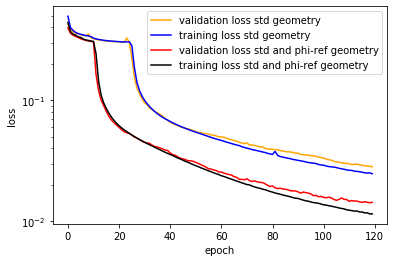

In [5]:
import matplotlib.pyplot as plt
import numpy as np
dataset = 'all_track'
#dataset = 'all_track_lowpt'
#dataset = 'all_track_id'
#dataset = 'all_track_lowpt_id'

if dataset == 'all_track':
    validation_loss = np.array([0.35753407786458224, 0.33973608827691965, 0.32951100151249246, 0.3125648717843207, 0.32301026428655044, 0.3009340740950768, 0.2967372560652636, 0.2928245788408538, 0.2888053296817898, 0.28540526298479846, 0.2826013344745178, 0.2801820658441991, 0.27823357530738, 0.27592553805328357, 0.2745846993421431, 0.2724067432395482, 0.2707186102867126, 0.26930784448391976, 0.26796592049679513, 0.2666509353845133, 0.2657379187685622, 0.26425729757648403, 0.26315432137015177, 0.26201676286883274, 0.2556185513440162, 0.2258006596295847, 0.20678207083778866, 0.16507962033320955, 0.1296970991754515, 0.10771234627013321, 0.09537291094913321, 0.08655455223847665, 0.07952708055786158, 0.07517331674337219, 0.07080961863147253, 0.06782351338730777, 0.06442801941470322, 0.06126540436430461, 0.05913273398922283, 0.05710478834281702, 0.05574227046842376, 0.05500011277453458, 0.054275659850067166, 0.053317407527043996, 0.05136839879813504, 0.050192896508885344, 0.04903147333501549, 0.048242406008138956, 0.047817538560389165, 0.04704613377574284, 0.046018698417692114, 0.045125320197035704, 0.04445817833371713, 0.04379826412578298, 0.04323860708016397, 0.0427886231230193, 0.0423883549153468, 0.04199172082517591, 0.04164942484099081, 0.04144331859628601, 0.04139872338618862, 0.04093995985402699, 0.040449879410358325, 0.04014945268291601, 0.039422626430195055, 0.039047262058093474, 0.03857149055752493, 0.03829496139482895, 0.03805268967930638, 0.03769935478270843, 0.03742828500946447, 0.03717725545103467, 0.036776056105078926, 0.0364738379323613, 0.0361809047539508, 0.03580809042435192, 0.03547879360076224, 0.03528337605553416, 0.03486662956926772, 0.03456224581110949, 0.034234575521217996, 0.03410043241288434, 0.033794758129551856, 0.03342632230267318, 0.03315625359954728, 0.033071672045303466, 0.032513317171751266, 0.03235537709101329, 0.03243303628731124, 0.032041757032051574, 0.03196566178677814, 0.03171388966542416, 0.031610944634467876, 0.03149915910677821, 0.0317172827859446, 0.031360221793842215, 0.03132059740653725, 0.030984406373437263, 0.031102982700584026, 0.030829193219404385, 0.03028163641502444, 0.030206032127331375, 0.029974967273876944, 0.029807845161837068, 0.029713766160256644, 0.029610561326574955, 0.029419896424232355, 0.029280194836980425, 0.02903366717095566, 0.028931266188326865, 0.02896300977257759, 0.02869037725603587, 0.028793318423220235, 0.029194863588716254, 0.02889717626148614, 0.028684225830342885, 0.02643411466370055, 0.026486093799782902, 0.026512732407989736, 0.026499329519765268])
    training_loss = np.array([0.4102505926716294, 0.3491965999411114, 0.336444925585246, 0.3228887534308337, 0.5062578115638577, 0.3093394267222828, 0.29945825798947384, 0.2961516462392726, 0.2912627367755282, 0.2877934695652944, 0.28486528328362076, 0.2822907501713262, 0.2799628123083273, 0.2777202056976046, 0.27571440277631676, 0.27392613944876415, 0.27232573391990683, 0.27085352709943084, 0.26949121879208515, 0.2681259926826835, 0.26695174631389057, 0.26565892326824453, 0.2645067432513829, 0.2634107312832112, 0.26406343883734806, 0.23796153860561298, 0.2177756867157085, 0.19111356578667327, 0.14669555849014218, 0.11808993856341704, 0.10091750867849632, 0.08976306204296357, 0.08277496228451343, 0.07637014650213723, 0.07174998310958246, 0.06803147525187532, 0.06488416762792343, 0.06220374401221558, 0.05999897316088841, 0.058182361188352384, 0.056407013812701225, 0.054880000987385484, 0.053521240795981424, 0.052281199459623354, 0.051178811381791, 0.0500456578924737, 0.04907315976302761, 0.04817689524936141, 0.04734025347036133, 0.04654881745621727, 0.04573468257091152, 0.04506723093368622, 0.04442334741047823, 0.04366553536071175, 0.04304153196932729, 0.042456477862717064, 0.04198407087588455, 0.041430500282721716, 0.040928066523864375, 0.040439236511057026, 0.039935209754070465, 0.039544799108869814, 0.03916741910102066, 0.03870769433633592, 0.038270514836906425, 0.03783248982062629, 0.03741569052681114, 0.03705417885960146, 0.036631143013071285, 0.036424208088192245, 0.03594846763286823, 0.0356245778195089, 0.035244582971828316, 0.034890929852933836, 0.03462340311226414, 0.034316990052045346, 0.03396857001966014, 0.03371608939652892, 0.03342373066370886, 0.033216060268482145, 0.03295152031672955, 0.03287495216723767, 0.03254807351329277, 0.032392729585374216, 0.03197610791533864, 0.031716708216348664, 0.031564332227204984, 0.03145541114742941, 0.03104597007530297, 0.030808853796505935, 0.03061906799734071, 0.030378777560011356, 0.030182696884323356, 0.029960798633390955, 0.02993644338324355, 0.029670605270043754, 0.029390824891683903, 0.029208174551769002, 0.029074298320725923, 0.02882833595067868, 0.028599929320211295, 0.0284395392848632, 0.028320024897497936, 0.0281197325939065, 0.02780473312056187, 0.02774539453077451, 0.027521636594540617, 0.027510824996727606, 0.0273544545306888, 0.027202395608282578, 0.02697007623583632, 0.026817400992507824, 0.02669184353550268, 0.02650401464488386, 0.026372627406373608, 0.026126306659698215, 0.024225922915345602, 0.024030314496834928, 0.023947293484909385, 0.02386768619056565])

elif dataset == 'all_track_lowpt':
    validation_loss = np.array([0.4486783851674721, 0.4620484985369073, 0.4392362071969415, 0.43191684080382525, 0.42262473781566834, 0.41528186956367924, 0.40519070797047374, 0.3985804466372829, 0.3922730982471994, 0.38953706420074075, 0.38426991589998793, 0.37990379299821153, 0.3890412575781009, 0.3746141463349768, 0.37202160732220796, 0.36900861717886846, 0.36708745143171084, 0.36455396381811905, 0.3633664397701705, 0.3707145147572803, 0.33598595349128635, 0.23920393724226008, 0.20938364191580627, 0.18753973365166768, 0.17369802255751723, 0.16254253089427947, 0.15258020427772553, 0.14313466689512555, 0.13649489301661988, 0.13275907571706394, 0.12751449733804174, 0.12299641810652226, 0.11842248390960154, 0.11598803510857841, 0.11433618675685872, 0.11243100966942512, 0.10929679506074237, 0.10538957671678, 0.10469480252030205, 0.1020490570256939, 0.1019333785536599, 0.09906697676932745, 0.09755331708465592, 0.09662605668444418, 0.09563952795950706, 0.09349963442333001, 0.09491394703081772, 0.0910578592475188, 0.09086699549340259, 0.09117604903666313, 0.08934496396594802, 0.0901412821295908, 0.08695059156855621, 0.08462938746321673, 0.08441347545065449, 0.08394164408499238, 0.08291010066109189, 0.08216261657449485, 0.08020966187708796, 0.0792454882572263, 0.08022635599735092, 0.07833816424264746, 0.07834178863861467, 0.07786853235151808, 0.07704732895613053, 0.07561732706334968, 0.07489699557381498, 0.07767343460924207, 0.07994000919710445, 0.07378434432344248, 0.07254431206248911, 0.07191370767093984, 0.07405140826341797, 0.07299034363974286, 0.07169376193719396, 0.06983641889893402, 0.07032005202214596, 0.06999444024121694, 0.06850018173582473, 0.06846652135126671, 0.06848713257218485, 0.06923869568328399, 0.06897723028636248, 0.06690890543415384, 0.06899111179140328, 0.06550418131137635, 0.0662686608163482, 0.06604864829467177, 0.07218940689907236, 0.06488776469213814, 0.06421897639073221, 0.06315725876997083, 0.0674433423806045, 0.06642898207709277, 0.062477030384085946, 0.06258682614287077, 0.06099599784839962, 0.06692488851015177, 0.06255823841455292, 0.06349991214182754, 0.059997088022235426, 0.06179125038959549, 0.06014844442870321, 0.06529686428438135, 0.05981379079995519, 0.06708376448664624, 0.05832823819065161, 0.06727856898333057, 0.06017088708441473, 0.059595960698558784, 0.05784457200917147, 0.06194945340607799, 0.057127983310380895, 0.05759449500569516, 0.060833445149289685, 0.05906809280694878, 0.05598363312708456, 0.060474124744450304, 0.05908562512805233, 0.06733874005744349])
    training_loss = np.array([0.47993041158227595, 0.4611036893253946, 0.44386047759951003, 0.4356850105585099, 0.4275523681709238, 0.41828037854704986, 0.4092665005022776, 0.40176084706570303, 0.39536489594180535, 0.3903243609383113, 0.3859977505385539, 0.38222438553716503, 0.3793074005562286, 0.37843427396153156, 0.37354430485264223, 0.3707468996119112, 0.3682355000505929, 0.3658783534689054, 0.36372023277342486, 0.3614203043250462, 0.35456222166586143, 0.27689926203413956, 0.22363424130404988, 0.19878644884779711, 0.18101962373228903, 0.168033815683576, 0.15752130440215312, 0.14856850687219725, 0.14076644201147354, 0.13449518940027402, 0.1294797834069442, 0.12496219369014568, 0.12135155150787852, 0.11804458328343843, 0.11510451739564496, 0.11246931353862802, 0.1100454744803956, 0.10796748849926359, 0.1060871301260961, 0.10413698435861007, 0.1025839263065534, 0.10087794069553288, 0.0994173008685479, 0.098069552945152, 0.09693327156621646, 0.09550571390480266, 0.09410497363483122, 0.09329300086634855, 0.09174989527196618, 0.09149113367245885, 0.089639985814196, 0.08877649160935991, 0.08797246090591607, 0.08725326609176894, 0.0861215782457026, 0.08517470872319056, 0.08445127344148307, 0.08350286435791013, 0.08286547516196398, 0.08182948174962701, 0.08147174373497966, 0.08032163064847937, 0.07985012145057889, 0.07886344202107481, 0.07850833025979309, 0.07783671878186176, 0.07702402161279072, 0.0765481478097917, 0.07600200107639477, 0.07543847060993861, 0.07480384715593362, 0.07397480268362847, 0.07371102387709069, 0.07293526065998873, 0.07288854530720451, 0.0717150111864242, 0.07171922594724528, 0.07124775942772796, 0.07031209548043435, 0.06988002101977561, 0.06992847921581949, 0.06917596310653361, 0.06864498719167869, 0.06839422404892363, 0.06771450469501863, 0.0676729910945162, 0.06736121902381738, 0.06659171847681815, 0.06611434275568542, 0.06602057482584217, 0.06565563844011749, 0.06541173002290629, 0.06507784035319915, 0.06443450493885383, 0.06410742453023223, 0.06450611594827625, 0.06377456979734013, 0.0636613038079129, 0.06304947306444121, 0.06266274276560456, 0.062410529446393505, 0.062128282562529634, 0.06179819823279556, 0.06161972070454835, 0.061489289348923976, 0.06103845108642458, 0.06096363873720843, 0.06083270706733594, 0.06031595528557223, 0.06017311246628942, 0.06013538473809275, 0.05989641178725551, 0.059529710620231296, 0.05931694165995544, 0.05915134040359934, 0.05867007155744833, 0.059173584390842054, 0.05842507396440553, 0.058225847422908254, 0.05777869800153047])

elif dataset == 'all_track_id':
    validation_loss = np.array([0.4011990266415359, 0.36953385566587504, 0.35846801782395205, 0.35215275610065727, 0.34612416555147385, 0.34216062901383737, 0.3389183472863025, 0.333797733889798, 0.3292173155536086, 0.32325470514048293, 0.3255816067511079, 0.317337005252892, 0.31528084288209174, 0.3133333043105858, 0.3115450240461166, 0.3099856186637097, 0.3084775406256907, 0.30726032435557266, 0.306145714728509, 0.30493043203980236, 0.30407587864809793, 0.30338548151618344, 0.25775706209452814, 0.1773496547871727, 0.14116962716235953, 0.12240858002234313, 0.11265446944214867, 0.10382559613908751, 0.09709276920658047, 0.0916624641714165, 0.0874759531285256, 0.08398648127492539, 0.08106191391283173, 0.07868203848368872, 0.07794943430361018, 0.07671847665934997, 0.07452212546315402, 0.07254904180102177, 0.07033168920421036, 0.06880094279445666, 0.06705342526258216, 0.06626022168800845, 0.06491573218816607, 0.06377858010667907, 0.06266200773307454, 0.061844846615331024, 0.06124127957539759, 0.06047692479280292, 0.059735140808013475, 0.058644536790624785, 0.057487255009483165, 0.05678875648757274, 0.055869014404311586, 0.05475982679823666, 0.054177214862057926, 0.05338152088889179, 0.053282919787607116, 0.052405946341864136, 0.05191665110369029, 0.051182839801695496, 0.05064093752081458, 0.04999765264795104, 0.04890004823649944, 0.04860069818398784, 0.047833604761793956, 0.04700124223820476, 0.04620767356633829, 0.04542097358975565, 0.045052140709775694, 0.04425445033943065, 0.043597498182342174, 0.04281706497729901, 0.04247726980324816, 0.041871259054435436, 0.041460411998510395, 0.04097494351084668, 0.04072928070893122, 0.04040051624338382, 0.040116892901093354, 0.03946425442037628, 0.03898521875886978, 0.03830057585766173, 0.03813960247921052, 0.03762975417649424, 0.03724793814914235, 0.036803214082699584, 0.03673739596268381, 0.036060888427168286, 0.035978903636875, 0.035538182654819256, 0.03558856061116153, 0.03499702765168306, 0.03459391138371834, 0.0345049655866529, 0.0341077493425093, 0.03381078976945094, 0.033757093787557674, 0.03360479117606603, 0.03327973781729553, 0.03350865630487882, 0.03321385895728139, 0.03295824541425856, 0.03334846008050395, 0.03261336652056569, 0.0327600914571404, 0.032524594711665966, 0.032217674336223835, 0.0323165068846021, 0.031835668762152, 0.031729280392509114, 0.03220136574884524, 0.03161165881610941, 0.031784790315080594, 0.031197683244702238, 0.030596300437148675, 0.03125249125922722, 0.03150753988154327, 0.03080021922595307, 0.03095365190896762, 0.0305941814572503])
    training_loss = np.array([0.46731301483377224, 0.38203490059296624, 0.3706722406928275, 0.35500379929603154, 0.349386865654592, 0.34509822056170997, 0.3413280435774665, 0.3372093413635499, 0.33892955379771056, 0.32642852033930436, 0.3253252067219066, 0.31997896289837013, 0.31686577242062464, 0.3148170556112766, 0.3130359963584944, 0.31137355724954713, 0.30987679412572694, 0.30844908844190255, 0.3072806655121494, 0.30626787355637947, 0.30522010200078165, 0.30438963256218593, 0.29778241141604544, 0.20966281277840526, 0.15850731290319126, 0.13161514010438222, 0.11698160958979516, 0.10735900312929156, 0.1004208921527031, 0.09485291590015364, 0.0904811437974344, 0.0867003560518648, 0.08353450583836812, 0.08078499351162628, 0.0783823250816886, 0.07614721110211715, 0.07404613678599198, 0.07219840725341228, 0.07043328931790531, 0.0688305397211094, 0.06747476811034499, 0.06612676989384274, 0.06468682026221709, 0.06332661675243008, 0.06205642365830756, 0.0609111129684956, 0.059969893132154665, 0.05872734786366711, 0.057770260239059575, 0.05676683748527461, 0.05574923650271306, 0.05478423202839622, 0.053914905509758436, 0.05314655698968975, 0.05232745850965119, 0.05143139843487602, 0.050692400877606576, 0.04999888300869835, 0.04917979728401981, 0.04860311765675868, 0.04769566160186545, 0.04694929563828927, 0.046310057268475265, 0.04560978688402177, 0.04505585357425437, 0.044383792474725, 0.04376622453528758, 0.04298540890034527, 0.04239866229489048, 0.0417405310636639, 0.04120017173658593, 0.040557126834784026, 0.04003498437279277, 0.03965401403402314, 0.03917456103870323, 0.03880542721682403, 0.03816137059826646, 0.037681623486568276, 0.03721514413661865, 0.03674313412145141, 0.0361766434173719, 0.03579429127313878, 0.03539146542225687, 0.03495153489808798, 0.03448164826915215, 0.03407698269703131, 0.03366793985723578, 0.03322987456597776, 0.032795960838390044, 0.032404499807636974, 0.03203631753434548, 0.03189518354398865, 0.03148368886530665, 0.030963292356568417, 0.030700151897679457, 0.030223406615492953, 0.030074561563298893, 0.02961596932016935, 0.029302177944574438, 0.02895607703973483, 0.02879766678891706, 0.028490475434845865, 0.02815720177943154, 0.027926562076300402, 0.02762192604786627, 0.027350546253604717, 0.027085474172632802, 0.026962173642340527, 0.026648115441297714, 0.026435469862926664, 0.02612610984412883, 0.025831523084795888, 0.02551999294834496, 0.025303890960940743, 0.02518741001282761, 0.025023370599964408, 0.02481887810883029, 0.024543527107367562, 0.024206573976397968, 0.024033894758122638])

elif dataset == 'all_track_lowpt_id':
    validation_loss = np.array([0.4770022643793185, 0.377337619967464, 0.37036661002627114, 0.3636701542852541, 0.3579803331265763, 0.4037324292637871, 0.37367238110920553, 0.3614408328082139, 0.35583079925943484, 0.3509211661320411, 0.3473066444808649, 0.34423990052267067, 0.3415515919921046, 0.33867461766816126, 0.32676077836935047, 0.26659034620075994, 0.22233114562307796, 0.19595067310383765, 0.1793625572391149, 0.16854359301354335, 0.1606764441769107, 0.15500223804607272, 0.15083043282656894, 0.1475257315728182, 0.14480808246380908, 0.1425052978792938, 0.14051215026111968, 0.1388696324459072, 0.13735789548221575, 0.1359808014397967, 0.13470926861105076, 0.13347777888694473, 0.13225619348771028, 0.13122833840875217, 0.13000259525800323, 0.12886762255697518, 0.1277041720571049, 0.12652486627842535, 0.12533971815012226, 0.12416233574592714, 0.12295137482858394, 0.12173519942693749, 0.12050477736419077, 0.11924533588985392, 0.11799462527131378, 0.11672223460371212, 0.11548924583568117, 0.11428490840293215, 0.11305971828284068, 0.11184417158970346, 0.11066589846228392, 0.10950575077032808, 0.10840367320609295, 0.1073574237183452, 0.10635458796658674, 0.10537907575641227, 0.10446961233155581, 0.10357884293301084, 0.10271271718744883, 0.1018739780016496, 0.1010415799255446, 0.100233892647097, 0.09943590224667921, 0.09865912851498668, 0.09789838333282683, 0.09716405040100427, 0.09645122909881595, 0.09576270967001085, 0.09502518717015404, 0.09443290169235045, 0.09363558706643302, 0.09310762084610129, 0.09238243286858318, 0.09187964267968227, 0.09119662180500852, 0.09066476859020774, 0.09010639729762271, 0.08960350726515391, 0.08896096000884592, 0.08842275267477426, 0.08783844664842838, 0.08734286936607717, 0.08683147898935686, 0.08623512867788158, 0.0857279825400519, 0.08539268841880168, 0.08480367145111711, 0.08426974124030479, 0.08383129580580435, 0.08324968430218892, 0.0828546131974202, 0.08218732407897984, 0.08181018086076625, 0.08118864193250883, 0.08066951777288785, 0.08022451637533762, 0.07989338659194671, 0.0791432975921622, 0.07873562402433931, 0.07806084513608998, 0.07762784980524247, 0.07724861602369948, 0.07663166691946381, 0.07639737940909036, 0.07565810492506914, 0.07527173063678319, 0.07467676242116292, 0.07457277126476106, 0.07376174645440516, 0.07343711830494074, 0.07307122918608792, 0.07259441824632534, 0.07220284452814461, 0.07177742470731949, 0.0713487137773332, 0.07109005240418312, 0.07055343409189901, 0.07042454451054209, 0.0698356722306597, 0.0695133419887631])
    training_loss = np.array([0.380618291520803, 0.37288960112353503, 0.3660363933124111, 0.3606305828370617, 0.3544248837367289, 0.5109187728604354, 0.364251619223821, 0.3584086482302617, 0.3528331290362245, 0.34892060187576857, 0.3453790601195589, 0.3424366316889639, 0.3399438886655926, 0.3353825452974287, 0.29851028852711964, 0.23944671584219582, 0.2051952915592382, 0.18502322113783345, 0.1720253208431147, 0.16244137439519, 0.15663336819342974, 0.15236868351529548, 0.14766302041414767, 0.14426509717342545, 0.14261411763938134, 0.14044585630802786, 0.13911132804081264, 0.13742593732678285, 0.13634105075550618, 0.13504770088751436, 0.1334283151532297, 0.13253804316881013, 0.13100298541245486, 0.13050436593886822, 0.1292319017993865, 0.1281739849197326, 0.12702233597299473, 0.12582931553913376, 0.12452938814705375, 0.12332686040192674, 0.12212526128537911, 0.12093495202940063, 0.11962427089022377, 0.11820768333003345, 0.11691991858984117, 0.11561318893553847, 0.11444123930766084, 0.11346742323899674, 0.11227597243199915, 0.11117252409879097, 0.11008162372193094, 0.10879555815609834, 0.1076853598915251, 0.1067124121312031, 0.1057069119718452, 0.1049037612553707, 0.10415278091016462, 0.10342661042166296, 0.102612406368983, 0.10174309793586112, 0.10078504242971119, 0.09974604543656279, 0.09882304059331026, 0.0980230691911137, 0.09736870144635944, 0.09650032055159073, 0.09580684510496376, 0.0950992693714166, 0.09496865921185516, 0.09432608649808134, 0.09312688520146628, 0.09247226222591885, 0.09195655017754452, 0.09125389980394288, 0.09049391282227753, 0.08983297309717216, 0.0892623571899988, 0.0898735324499634, 0.08880651824723529, 0.08764597685576159, 0.08714123589675979, 0.08670643524261518, 0.08613479071333584, 0.08557440372931081, 0.08517416255117136, 0.08474989293911363, 0.08426999754067195, 0.08394759591605704, 0.08345695366967196, 0.08273296379352693, 0.08229579157748465, 0.08178694490659034, 0.08177402997336819, 0.08055778883692236, 0.08006952222289339, 0.07943976981154943, 0.07929484654365286, 0.0785789998911195, 0.07858359340136334, 0.07751867307276375, 0.07728151115404684, 0.07686797635114126, 0.07698138154159158, 0.07582124479030822, 0.07527103993599697, 0.07459235666793282, 0.07411697205934821, 0.07380251850364572, 0.0736780051562914, 0.07273092553819303, 0.07229066205942361, 0.07342359137400395, 0.072290566245799, 0.07178170080954409, 0.07416853044960796, 0.07010353869090309, 0.07080469230600332, 0.06952310820546864, 0.06910146443057531, 0.0704257090107701])


    validation_loss_2 = np.array([0.38284382133160605, 0.3663090908257975, 0.32942379654127324, 0.29974973078838174, 0.2707223886150425, 0.24858530173025561, 0.22897225277403654, 0.21233874281584206, 0.19936314037459044, 0.18869350612331917, 0.1791261582724792, 0.17302644215734664, 0.16734042416016262, 0.1587203288145658, 0.16320973140540096, 0.15256467132413454, 0.15287519147840598, 0.17257382048051909, 0.15805178973297615, 0.1388613600683751, 0.13690747202789716, 0.13483427053285857, 0.13345990109830927, 0.13423055864154956, 0.12909149450939253, 0.15528294736214276, 0.12563019599449837, 0.12400750138160199, 0.12270044658312017, 0.12083279330093982, 0.11883739398445113, 0.1452620998866814, 0.11543752232429672, 0.11314831903930438, 0.11343390202454928, 0.11052521595173637, 0.13357762052851208, 0.10820818336333259, 0.10593887325902443, 0.10468283415177447, 0.10363503851964649, 0.10352113492323854, 0.10357808006853707, 0.10095091345535834, 0.09936182106197891, 0.10079153472673422, 0.09792036332484692, 0.09690774229202567, 0.10736200846942132, 0.09601203520166672, 0.09799581353189582, 0.10630083861576635, 0.09301321971635361, 0.09319775461477076, 0.09210925870443468, 0.09210609372305331, 0.09402621517242012, 0.09769649202961707, 0.08976622747499391, 0.08956426662829636, 0.09464932862395621, 0.08846789759262808, 0.10384948271731873, 0.08873459080097365, 0.10136672522304421, 0.0873883424842425, 0.08655752788408327, 0.08856321663337913, 0.08680353923621824, 0.08628840065524403, 0.08499765654152396, 0.09101666452015861, 0.08479106213245015, 0.08403872582787848, 0.08693051579392562, 0.1343433636772094, 0.08402541311363042, 0.10888117625888458, 0.09675084496453656, 0.09547074587836778, 0.09240658735319719, 0.09161513537421065, 0.09078114934812831, 0.09008032192113036, 0.08918257506385362, 0.08838469428194445, 0.08793034136379506, 0.08774395532443025, 0.087531574154641, 0.08732182287563713, 0.08711351270729539, 0.08690771340987104, 0.08682238911252237, 0.08677468564214005, 0.08672469060047198, 0.08667373627340053, 0.08662255900559453, 0.08657151427814516, 0.08653750696172148, 0.0865046272969852, 0.08647160885781892, 0.0864386272842938, 0.08640575621087672, 0.0863730301501724, 0.08634046321619028, 0.08630806100738925, 0.08627582269031449, 0.08624375092528634, 0.08621184476940645, 0.08618010280832733, 0.08614852325727711, 0.08611710163327933, 0.08608583512868585, 0.08605471533318024, 0.08602374312231097, 0.08599291631562561, 0.08596222776982744, 0.08593167919391966, 0.08590126674895907, 0.08587098950046604])
    training_loss_2 = np.array([0.46881578328603574, 0.3745713815840203, 0.3487120172861269, 0.3138115713478061, 0.2860942351037247, 0.2596198202394959, 0.23940404168840518, 0.22317402553349985, 0.20813067360270748, 0.19499341866506611, 0.1852278004802953, 0.17681927039777323, 0.16895971570353388, 0.16512307451017158, 0.15826672895306373, 0.1550329557980416, 0.15131817578790593, 0.15402436713256615, 0.14675276073637697, 0.14202268716700292, 0.1398046768775557, 0.13797744122954705, 0.13568718736533517, 0.13376486829960835, 0.1320159563776316, 0.13039839936362443, 0.12864817257070818, 0.12710368049352055, 0.12432110874839969, 0.12282402440116315, 0.12152378706098403, 0.1198450200414906, 0.11734288220035996, 0.11606241288163441, 0.11422333325717156, 0.11248602217989369, 0.11089741587665164, 0.10947561931485932, 0.10828704090320668, 0.10654400855218624, 0.10579768202193923, 0.10591388655968516, 0.10317193258469556, 0.1025763800457162, 0.10172876014011138, 0.10024840081384205, 0.10115856107976814, 0.09885449511904038, 0.09789202843745382, 0.09781428231163171, 0.09901193755620953, 0.09648779544211124, 0.09489736409389576, 0.0961196557973843, 0.09421772691868456, 0.09503959646017032, 0.0955736846189504, 0.09263291283863159, 0.09155702646387646, 0.09343210761737879, 0.09306411053143483, 0.0906532814918286, 0.09520167425487948, 0.09131808549568246, 0.09336985123612113, 0.09157831214123674, 0.0915047072103026, 0.09005927497068536, 0.08846339037626098, 0.08925883841600879, 0.08631596730964121, 0.08906721449943818, 0.08636042498391501, 0.08537891455649761, 0.08594263015883201, 0.09213146757621234, 0.08901267549704424, 0.10292334700171642, 0.10314358961847374, 0.09768974814185147, 0.0930179490228999, 0.09200202517795487, 0.09122295914636136, 0.09039012810260079, 0.08953198223929894, 0.08870759053289953, 0.08802171845231099, 0.08784476863772814, 0.08764764565137863, 0.08743855452209733, 0.08722644485204381, 0.08701597900974359, 0.08683717604608164, 0.08679095728949007, 0.08674227524848686, 0.0866917402899198, 0.08664053774275686, 0.0865892738874707, 0.08654110855488685, 0.08650856563560981, 0.08647563963428687, 0.08644259607387801, 0.08640959500966562, 0.08637670629018507, 0.0863439646848125, 0.08631138125760744, 0.08627895797908011, 0.08624669526819413, 0.08621459416479482, 0.08618265213865765, 0.08615087030263417, 0.08611924670726102, 0.08608777795544705, 0.08605645901370941, 0.08602528707229527, 0.08599426114858039, 0.08596337870773622, 0.08593263776346746, 0.08590203811056743, 0.08587157814224161])

    validation_loss_3 = np.array([0.3791239040887962, 0.36987587541846906, 0.3632126099645755, 0.3543947558618535, 0.3488845401732935, 0.3494983194238048, 0.34106747430596646, 0.3884781202354, 0.36913947823357446, 0.36061231431651253, 0.3522006602105448, 0.3467577536227339, 0.3425878386713017, 0.34157669172111876, 0.3405677236069394, 0.33945073076223925, 0.33824337101252067, 0.33693847844829666, 0.33567779126477104, 0.3343387059741101, 0.33302447011241804, 0.33174680727349837, 0.3305483090843858, 0.3293746716053472, 0.3282621374743133, 0.32716427665982545, 0.326115366075672, 0.3251259497666763, 0.32421183262841174, 0.32338333555870813, 0.3227852087068019, 0.3218746744811872, 0.3211872239570833, 0.32051208883018817, 0.31984915288828186, 0.3192082204387686, 0.31859227354917147, 0.3179955752050809, 0.31741283264874065, 0.31683393556856165, 0.3161907405503052, 0.31508145014108235, 0.31147154143637856, 0.2990122150229869, 0.27274902994181477, 0.2575931625009257, 0.24541038469237797, 0.235880662096759, 0.22743959959785817, 0.21890523935441916, 0.21144315667745084, 0.20522655502887768, 0.19980915670341018, 0.19501346199020828, 0.19051890700718777, 0.18668210427303097, 0.1832719275422689, 0.18001291560756286, 0.17755074452208933, 0.17483004036933014, 0.17225241139110198, 0.16989575399685714, 0.1679017199803207, 0.1661557823419571, 0.16456307719151178, 0.16324648678639514, 0.16221369061261248, 0.16121227520670595, 0.15968701190362541, 0.1583464466582584, 0.1571546050535757, 0.15604005972881102, 0.15498758335571505, 0.1539863203962644, 0.1530351259698302, 0.15212757206906033, 0.15126534410789189, 0.15042863060525583, 0.14962730103798505, 0.14884363635111664, 0.1480845125128994, 0.14734293820157562, 0.14661224111493698, 0.14589164686405054, 0.14519058918043717, 0.1445086855420285, 0.1438459427216969, 0.14320804957868688, 0.14259307877828845, 0.14199847556271797, 0.1414242118428656, 0.14086730971848224, 0.14032367626994344, 0.1397898003964101, 0.13926837657299418, 0.13877975512190727, 0.13833414029940375, 0.13791541484537098, 0.13751167238684697, 0.13711739233405576, 0.1367292479690859, 0.13634465103179721, 0.1359606115536838, 0.13558188031538057, 0.13521145775409069, 0.1348522644974081, 0.1345011797623109, 0.13415554260129983, 0.1338104156787786, 0.1334672471392626, 0.13313005441157832, 0.13279705153683485, 0.13246863600140238, 0.1321440746765689, 0.13182252052392662, 0.1315037204805067, 0.13118854735867452, 0.13087527070846935, 0.13056310439682275, 0.13025155499745897])
    training_loss_3 = np.array([0.4605066847729649, 0.37483767477406116, 0.36642309693398617, 0.3584898832322514, 0.3517938345528634, 0.34713291588349865, 0.34326500981509434, 0.3831236734407517, 0.37445554020156885, 0.36532839619170476, 0.3564001770958431, 0.3495978910086603, 0.3448250629244593, 0.3422495373287949, 0.34134155372420777, 0.3402814967031617, 0.3390971187154873, 0.33784961890387166, 0.33657320617240366, 0.335269951895616, 0.33396018979450065, 0.33266641698925004, 0.33142156247575744, 0.3302229100227945, 0.3290820933462747, 0.3279824038088785, 0.3269176867285396, 0.32590523793093734, 0.32494346720908407, 0.3240533770551368, 0.3234678142372582, 0.3224994288704826, 0.32177363602328773, 0.3210809774628425, 0.32041089647412724, 0.3197683584034485, 0.31915018219490254, 0.318550890687811, 0.3179654271136654, 0.31738403082251715, 0.31677624671904125, 0.3159898869156585, 0.31384226144159916, 0.3074469968681829, 0.2850622536988119, 0.2646485006641912, 0.2512197335155965, 0.2410478387264756, 0.23223420939181988, 0.223817231046762, 0.2159278166327773, 0.2091996643855368, 0.20341581689972577, 0.1982943956387666, 0.1936480318759121, 0.18940261126585348, 0.18560767147721627, 0.18224167950598702, 0.17924424154831275, 0.17649481468833983, 0.1740143671631813, 0.17175830268080078, 0.16969013874061237, 0.16776937912191964, 0.16599620838970536, 0.16434809004514356, 0.16280743614165374, 0.16136819183547577, 0.16000952730271017, 0.15872326409207435, 0.15750965525627683, 0.15636217983381687, 0.15527510070136755, 0.15424302640360502, 0.1532619960137806, 0.152327218708598, 0.15143431332041274, 0.1505788825991653, 0.14975843401388975, 0.14896924504720854, 0.14821067657637393, 0.14748000536682243, 0.14677329168465555, 0.146087837809339, 0.14542356217385263, 0.14478177918873644, 0.1441634938010346, 0.1435674207671782, 0.14299316453815852, 0.14244003868056723, 0.14190687594598547, 0.14139328246915156, 0.14089870498920817, 0.14042274142604974, 0.13996463794903147, 0.13951904238938317, 0.13907993839801117, 0.13865014398996692, 0.13823099211542367, 0.13782011894088259, 0.13741666982134562, 0.1370193725728067, 0.1366253471157203, 0.13623292486335936, 0.1358423176574084, 0.13545629705202444, 0.13507684472800985, 0.13470411987180722, 0.13433783236064942, 0.13397752467969085, 0.13362279822286954, 0.13327364339019662, 0.13292900851985576, 0.13258850948206322, 0.13225210145889324, 0.13191931006777505, 0.13158965133009531, 0.13126278942119393, 0.13093857262625574, 0.13061684809788263])

tl_std = np.array([0.4948669742782321, 0.39915494286155295, 0.3779163824625861, 0.36385835683773043, 0.35581750518216165, 0.3509161559638625, 0.34676192130230493, 0.3430987358866733, 0.33974408104984183, 0.33617311256732474, 0.32639643197384594, 0.3214299739404229, 0.31816000279465345, 0.31555017977979266, 0.3132110887422821, 0.31127746505426024, 0.309778610150998, 0.3083123842985659, 0.30717965538908154, 0.30599111682698554, 0.30508030350793597, 0.30410383445458056, 0.3031688866660651, 0.30371310642399524, 0.3043659612981045, 0.2830682893988734, 0.18597231547862533, 0.14041143971545317, 0.1200937380201787, 0.10803839468412328, 0.09971451204178702, 0.0935393628442912, 0.08840050418235725, 0.08414585270519262, 0.08050225573740039, 0.07738940049300978, 0.07469393058759663, 0.07229864699951638, 0.07033481331010044, 0.0685951774038827, 0.06678287786972005, 0.06514165483310591, 0.06364267457607989, 0.06227535012267819, 0.060968780043054144, 0.059710644416559856, 0.058540261939040876, 0.05741434560719416, 0.05638555817367271, 0.055450458379165075, 0.054531862026514666, 0.05357607791777958, 0.05276854496846656, 0.051844995578199805, 0.05103820782609402, 0.05019058868842388, 0.049368645395689026, 0.04860232941151521, 0.04781426939723138, 0.04716908695171064, 0.04655564834866314, 0.045873631132772937, 0.04511951739678, 0.044533294475801434, 0.04386526649757973, 0.04325274053078027, 0.042680296638272046, 0.04221105598150392, 0.04134581953043108, 0.040746972002374614, 0.04022581297452126, 0.039750285384087806, 0.039140408714299, 0.03878775148680272, 0.03832775515466394, 0.037886208459617515, 0.03744566672185486, 0.03704889006040904, 0.03645783598311562, 0.036056926790221135, 0.03568018004310645, 0.03779618620455564, 0.035009973793321325, 0.03431850759768673, 0.033861465368978945, 0.03358462248267853, 0.03320121757306843, 0.03290587576946893, 0.032435486429113876, 0.032184861206529365, 0.031855086732185546, 0.03161670742985033, 0.03131332029585142, 0.03095136013696755, 0.030577104142617946, 0.030412725076020494, 0.0302207669815096, 0.0299971128213047, 0.029473232001796315, 0.029202247091176504, 0.02906773251101183, 0.028616139513665487, 0.028334763561804074, 0.02817002274724861, 0.028062866903613697, 0.02779828963685331, 0.027401485549027924, 0.027154685946879458, 0.026914699269198247, 0.026583614124772687, 0.026377029492579942, 0.02634732563381227, 0.02596842025142827, 0.02581977787853592, 0.02569507308684598, 0.025431995686687005, 0.025182752325671083, 0.025026640006211246, 0.025161502211041208, 0.024694022560569052])
vl_std = np.array([0.4230934201071491, 0.38291962140024044, 0.36957715402888713, 0.35816079805799794, 0.3547134679168631, 0.34768012309983626, 0.3438832527584275, 0.3400208251035146, 0.35367661326450145, 0.32784682617517513, 0.32307432784704165, 0.3190188656250636, 0.31586956491241347, 0.31327234273408094, 0.3112651546038477, 0.3094788406780884, 0.3082348580245918, 0.3067938901357732, 0.30575339238522414, 0.30478070732732276, 0.30400452723274124, 0.302954993300182, 0.30209138928833656, 0.32671080017830695, 0.3011456662399621, 0.2236555929069465, 0.15447689017838678, 0.12607525973607087, 0.11355240544735712, 0.10224886239943026, 0.0952016032527143, 0.0919149569546183, 0.08589828877083662, 0.08337359353005465, 0.08084748694357478, 0.07879134417737776, 0.07654556788735639, 0.07411065358605426, 0.07088344592211694, 0.06831083404857898, 0.06588989774707052, 0.06418442848522617, 0.0627591359110728, 0.061597668380992184, 0.060322658236843595, 0.05943213486425726, 0.05844412899384075, 0.05807129568499276, 0.05713341007374837, 0.05617982286270603, 0.05517069709429381, 0.05429715119337789, 0.0539568602328457, 0.05335763632714496, 0.053023916595854856, 0.05261866294951204, 0.051719285477949885, 0.051469999236596675, 0.050797069182627344, 0.04991176307864361, 0.049753460048903096, 0.04949791451546463, 0.04843739481862518, 0.04783775448999078, 0.04702947352326207, 0.04641877184082664, 0.046047529697518186, 0.04493999308876898, 0.044441149857205646, 0.04384463352271577, 0.04443600269647494, 0.04262415099919295, 0.042789270432690936, 0.042259005753495754, 0.04181953195754128, 0.04109630129562486, 0.04131570212354905, 0.04014386949796982, 0.039637441462988435, 0.03949292841361504, 0.03937019373130416, 0.03909144602064175, 0.03898062248376204, 0.038391416191483854, 0.03810810471775068, 0.037669336988697864, 0.03751523363026448, 0.03741984826934887, 0.03705135141387529, 0.03662819034573859, 0.03655535864780557, 0.03569156511770272, 0.035451473085762866, 0.035281889236648566, 0.03523829515518931, 0.034826073353754296, 0.03476740746868388, 0.03441317397913643, 0.033985823740436835, 0.03358701656975042, 0.03323898353555706, 0.03265674080190612, 0.03222811138584597, 0.03199836285526688, 0.03130231904604875, 0.03086315232964093, 0.030857732467646684, 0.03029804283835745, 0.030175646110547977, 0.030119440891728327, 0.0299091107231574, 0.029427459885877305, 0.02953791400968685, 0.029744077416797535, 0.02923958357730203, 0.029131658805901246, 0.028700614918131376, 0.028655797865335984, 0.02854004755205035, 0.028189056211996015])

tl_z = np.array([0.4741046464012799, 0.38240565315394076, 0.3615918808306257, 0.3525414295036788, 0.34735350275812094, 0.34319099165120365, 0.3382436489702155, 0.3366980849749456, 0.3239034933832574, 0.31963347162298944, 0.31672715235075327, 0.31497680147225826, 0.31259016357599045, 0.3108154718230063, 0.30937815709092187, 0.30804175831309105, 0.3068729455301296, 0.3055941326488441, 0.2562252037479716, 0.17651542420183325, 0.13682075085724826, 0.11723326371351617, 0.10640250157068633, 0.10324035282411197, 0.09371253484339646, 0.08884794188128642, 0.08473876537146746, 0.08114282490379664, 0.07796263599688616, 0.07514782921923867, 0.07273558326108538, 0.07049723410906195, 0.0683856572467741, 0.06652959213665448, 0.06480410631462744, 0.06312401945410398, 0.06161628411449022, 0.060198369626271356, 0.059097729991149234, 0.05772445911792355, 0.05646543782696339, 0.055354172887586955, 0.05430203716354566, 0.05323557352859216, 0.05229444309424443, 0.051351358836803994, 0.050472488082471755, 0.049484318898698726, 0.04869325245911923, 0.047953082293208285, 0.047170888016957034, 0.04639642668699723, 0.046129387255901017, 0.04510688109176712, 0.04454304137794104, 0.043840084925649773, 0.04327908160631025, 0.04268671253829508, 0.04215496472608006, 0.04164376820369018, 0.0411691495257226, 0.04063504761320011, 0.04014765113148227, 0.03963244080706051, 0.039098770612895996, 0.038705098977373585, 0.03833025519066135, 0.03789816099744499, 0.037358755035426974, 0.03698656804118146, 0.03649421450174196, 0.03609549170826445, 0.0358136876315235, 0.03530316115062321, 0.03473981625771522, 0.034270209511639435, 0.03386640633405639, 0.033967684352442656, 0.03315494883855217, 0.03295168197331995, 0.032719002949181494, 0.032335008182131676, 0.03201779106053362, 0.03177033142492035, 0.03156257891796074, 0.031056782176637876, 0.030647977496791597, 0.030466508503072656, 0.029931270194017968, 0.02971843742662035, 0.02939617670730774, 0.029095234411587855, 0.028857285205755794, 0.02852125571806446, 0.02834646628442612, 0.0280871823402095, 0.027783823441776455, 0.02746710629431884, 0.0272689393047902, 0.02697335506752873, 0.026709780129574534, 0.026250507807821327, 0.02597938456937021, 0.02583990853150298, 0.025485851383063782, 0.025298575732298916, 0.025135878965329216, 0.024897212359256772, 0.024638502863664556, 0.024480194425442112, 0.024241479556974227, 0.02401636246101472, 0.023873972800115256, 0.023644080171055876, 0.02343465110634205, 0.02316529065539583, 0.022902184993087545, 0.022872328274538542, 0.02253883206046129, 0.022435075016712783])
vl_z = np.array([0.40418679695681664, 0.36921324629736485, 0.3566655499029294, 0.35047921391866976, 0.34606572191762386, 0.3419126338793733, 0.3387477578584757, 0.3280952046146501, 0.3231650121215373, 0.319595075908017, 0.31718739332620705, 0.3150500110734654, 0.3136379555541243, 0.3119675936251037, 0.3107571266044331, 0.30945413818130385, 0.3084637917957063, 0.30583286545539307, 0.2062139766574916, 0.1528531021549035, 0.12401058473650597, 0.11020523512493924, 0.1018653081677391, 0.0966566604341112, 0.09194163541299012, 0.08844023205650349, 0.08408747597644894, 0.08047564569584457, 0.07717751775747218, 0.07486477157477248, 0.07298692858535902, 0.07117852581826717, 0.07010385242447331, 0.06780305405793248, 0.06539776282823029, 0.06362781921174052, 0.06242420111992002, 0.060847276586534105, 0.05977315089558804, 0.0593630239222788, 0.058869411720825875, 0.05708510566846136, 0.056437063859420496, 0.055043639994876215, 0.05358608136161383, 0.05313671485939863, 0.052398748465716356, 0.051477679867467756, 0.05130409769849368, 0.05091119665166792, 0.05010930358841331, 0.049595801558281104, 0.04882244328977435, 0.048269349239693594, 0.04770020880562281, 0.04669823763112006, 0.046375125126421876, 0.045897101100825566, 0.04579373057439198, 0.04487451812775942, 0.04510710542865517, 0.043983556155095964, 0.04364670359919332, 0.043406548589696725, 0.04320644225828112, 0.04295135781998561, 0.042474581113496716, 0.042205843191663275, 0.04156597606272691, 0.04132057145086402, 0.040984951389847764, 0.040316072277827346, 0.03983753082827674, 0.0391291732671618, 0.03902261608638202, 0.03833138179205, 0.03778350048896292, 0.03808689965415314, 0.037585408658422775, 0.03680820928538438, 0.03681323828156261, 0.036319569461069845, 0.03607383042151841, 0.0356145449778878, 0.035484876985939814, 0.03540177480939192, 0.03507563425527876, 0.03504325236044576, 0.03474856782146357, 0.034233111474893795, 0.03417430345529242, 0.03393952934347703, 0.033705349025493464, 0.033892206096698435, 0.03384720862432313, 0.03349151302008463, 0.03323631738956074, 0.03316436393167047, 0.03354207336561265, 0.03292051209707205, 0.03274532904998744, 0.03248737351179833, 0.03247901908798153, 0.03228742803279766, 0.03180299795359405, 0.031280538187060156, 0.03136893830874497, 0.031509565051593164, 0.03128493178591358, 0.0308819643833161, 0.030998283706254872, 0.030982142297253337, 0.030175659624502634, 0.029983997743835, 0.02941146282829235, 0.02931755108765672, 0.029201806292950626, 0.02898584599304864, 0.028684506578469215, 0.028575834808280645])
    
tl_phi = np.array([0.4902147324755788, 0.3927907915891143, 0.37240651171749173, 0.36042053033308374, 0.3528699969194072, 0.3463179348247115, 0.34003561751727585, 0.342438896907504, 0.329446288651792, 0.3250351795784624, 0.32176407843586163, 0.3192014202428192, 0.31666855365274693, 0.3148640633750139, 0.31284271904640953, 0.31124722637830693, 0.3166483650076082, 0.3099009564756758, 0.3084643356880899, 0.3073696360126201, 0.3063729621133225, 0.3053911697306265, 0.30438331296762167, 0.25598427955071723, 0.1650385796500233, 0.12743511100564056, 0.11089971784938332, 0.10038836434875525, 0.0926363236181807, 0.08674430264067792, 0.08213566464015498, 0.0782593898604452, 0.07517840973743896, 0.07229011906825578, 0.06989701492335566, 0.06764427952881603, 0.06578222282938842, 0.06431086043862012, 0.06249251801558898, 0.06093936096106204, 0.059615643720786406, 0.058299884686927574, 0.05713135206295675, 0.05596061563636214, 0.055025039452969285, 0.05400705017578566, 0.05307562670763434, 0.05211712651591349, 0.05133055248503595, 0.05050572093461524, 0.04967001390491404, 0.048803188154592246, 0.04800513550749124, 0.04734552719575556, 0.04681840356296546, 0.04599521481121765, 0.04528932096260733, 0.04472373225125612, 0.0443748515565994, 0.04344475000684878, 0.042963429727891154, 0.042401717834677916, 0.041784860828608085, 0.041310983349075736, 0.040747748891208635, 0.04024895307426091, 0.039684241139852444, 0.039289039588432176, 0.03877106110856706, 0.03819576679343222, 0.037731033381503506, 0.037394380032196105, 0.03706864119485378, 0.03643315708997163, 0.03599990174405315, 0.03558681645476122, 0.035067059944847226, 0.03468738861129502, 0.03436543832632096, 0.033972395932479145, 0.033652486203274136, 0.03317404816880491, 0.032803001954230776, 0.03240708823149218, 0.03196920960606747, 0.03160980577550453, 0.03124560914513603, 0.030885511157216158, 0.03054867701141729, 0.03019723747263598, 0.02999129705857044, 0.02952611332819347, 0.029343392220088606, 0.029029939739656698, 0.028506041342823685, 0.028345261478975925, 0.02802571675884936, 0.02755216740397013, 0.02724934426083695, 0.026961998679640643, 0.026687159338390085, 0.02616880576462243, 0.025923312395740285, 0.026011695000527597, 0.025365162793239655, 0.025161709192612545, 0.024917613403256756, 0.024700792405096466, 0.024409473383890136, 0.024325922999444586, 0.02405074695044768, 0.02374799420684663, 0.023656672806226065, 0.02356651397117744, 0.023142877913156324, 0.023162707670270448, 0.022585518076616056, 0.022308906497024487, 0.0220355815841582, 0.021936643160196105])
vl_phi = np.array([0.41477042315369944, 0.3822079867713869, 0.36412185462517926, 0.3551875570315426, 0.3481643563020701, 0.3429695480119037, 0.3348994941024457, 0.33207468601775036, 0.3254203350867255, 0.32189209146351466, 0.31905517424904023, 0.3164107989709256, 0.3142470883784321, 0.31251834436493403, 0.3109750363281218, 0.30946984076398915, 0.3099360890307669, 0.30839308017896394, 0.3073927975391264, 0.3061653727697114, 0.30483834089364037, 0.30399945681377993, 0.3032858775918093, 0.19864000228081047, 0.13653743010077435, 0.11526463402929785, 0.10475092092002768, 0.09756012902316233, 0.09060739265086581, 0.08523215787527336, 0.08076318741307757, 0.07717312467600203, 0.0741968399196558, 0.07143592220404854, 0.0696979066601686, 0.06793198753930997, 0.06676390222806515, 0.0656176422071501, 0.063318748403726, 0.061317128044721475, 0.06055444354437407, 0.05913421513195712, 0.05849617956147666, 0.058125554673086936, 0.05707708896290035, 0.05588511622372402, 0.05544249738596503, 0.05459835401088023, 0.053735021260612394, 0.05370407614779348, 0.05300792677288199, 0.052017477474512144, 0.051740875773914195, 0.05049080921508507, 0.0497041366412551, 0.04848916724326364, 0.0481476797709208, 0.04727382877122875, 0.04738885855170179, 0.046699767604853046, 0.04594842125122346, 0.04630178488534645, 0.04542471996888697, 0.04484500838708367, 0.0450818660991144, 0.04383456691847831, 0.043974042455687146, 0.04329866462949983, 0.04272871310775803, 0.04243377236962466, 0.042032481658564796, 0.041564929487808024, 0.04088809105559742, 0.04010543794538329, 0.03934781494547776, 0.03918845318797956, 0.03876224430825901, 0.03819032265119617, 0.037578121351568475, 0.037367300383252026, 0.03659849043087169, 0.03655466651984232, 0.03617204627617213, 0.03559860312907301, 0.03549001268774227, 0.034836081293248604, 0.03448597738868886, 0.03438769187237265, 0.033492351842269376, 0.03345592185326439, 0.03287375577148162, 0.03285275264749189, 0.03276525255632856, 0.03259485165047095, 0.03274711704954599, 0.03221138600697563, 0.0320745065112024, 0.03151850511425498, 0.0312740574250495, 0.030744780355528894, 0.03032940665571878, 0.029892418296137195, 0.029437836490477445, 0.029371941273128133, 0.029077557473231992, 0.02875730708801506, 0.028942446219960113, 0.028541072139530943, 0.028595299764983897, 0.0285572972084612, 0.028137367396644384, 0.027652373028934557, 0.02817817749929125, 0.027508328216352487, 0.027449832903607658, 0.027548614358920788, 0.0271741374618876, 0.027223010703255054, 0.027065957796882895, 0.026918346630632983])

tl_std_z = np.array([0.4366045855314571, 0.3655040427860883, 0.35033033502361827, 0.3419556518645673, 0.32429482881374405, 0.321148835766487, 0.31406402218650165, 0.31091524760691336, 0.3085076163422927, 0.30632745423932994, 0.30453657249441257, 0.30684397166784283, 0.30255680490090475, 0.3007884273748834, 0.299530485035236, 0.29840175331225566, 0.2973603034249933, 0.2963812403738667, 0.2954977929880211, 0.2946576263247805, 0.29387868467407924, 0.2931848088395124, 0.2924951047059096, 0.29188276264858615, 0.2913083185771964, 0.29076178320736157, 0.29025286185820875, 0.28975548721273764, 0.2893064437864222, 0.28886197366433397, 0.2884443404427914, 0.2880563908927458, 0.28768165904691834, 0.28596834371939805, 0.2857842145206165, 0.2856487764419178, 0.28552129502226675, 0.28540095961836853, 0.2852871368085376, 0.2851785409137986, 0.28475422085470675, 0.28470567500581806, 0.28467684248291314, 0.2846498251346724, 0.28462377917692383, 0.2845983839591197, 0.28450077605410085, 0.28448662845323147, 0.2844800954391275, 0.2844741752832907, 0.2844684815993217, 0.2844629063978686, 0.2844495023212706, 0.28444542071326917, 0.28444191348268044, 0.2844384759756615, 0.2844350701296639, 0.28443168572250144, 0.28442831757928294, 0.2844249632256895, 0.28442162088326334, 0.2844182896614601, 0.28441496851385734, 0.2844116579416329, 0.28440835711277895, 0.28440506431329365, 0.28440178090727514, 0.2843985054576191, 0.284395237492087, 0.28439197792227006, 0.2843887264311503, 0.28438548182431966, 0.28438224460295597, 0.28437901320762005, 0.2843757888800754, 0.28437257010626504, 0.2843693586995057, 0.2843661528773932, 0.284362952930637, 0.2843597592768854, 0.2843565703843231, 0.28435338853587433, 0.2843502118129883, 0.2843470403498386, 0.2843438750435467, 0.2843407144958132, 0.2843375590144483, 0.2843344083751715, 0.2843312628410683, 0.2843281229041085, 0.2843249875316817, 0.2843218563554682, 0.2843187303936088, 0.2843156091889924, 0.28431249173400175, 0.2843093795867605, 0.2843062706083838, 0.28430316652142373, 0.28430006674906544, 0.28429697167344053, 0.2842938805809297, 0.28429079418383685, 0.2842877121204195, 0.28428463263852827, 0.2842815594108365, 0.2842784887113961, 0.2842754235722672, 0.28427236155267427, 0.28426930416667423, 0.2842662504316429, 0.28426320160578644, 0.28426015681566114, 0.28425711508390444, 0.28425407783117795, 0.284251044381352, 0.2842480147192991, 0.2842449894119686, 0.28424196681573377, 0.284238947954655, 0.2842359335002579])
vl_std_z = np.array([0.377408728954819, 0.3551881679833609, 0.34589032507633083, 0.33201922940163964, 0.3199583174060967, 0.31651810256101315, 0.31252693738472664, 0.3097042490028392, 0.3074149134974022, 0.30535822802007534, 0.30361995534960834, 0.3049927781067662, 0.30212991888829543, 0.3005044094376308, 0.2991380530646292, 0.29800665542735894, 0.29717545565322967, 0.29633127039687784, 0.2957141741015817, 0.2948307122424834, 0.29415442924209906, 0.293655519755715, 0.29310499065171525, 0.2926575416856903, 0.2920399775149795, 0.2915738698705442, 0.2910135799250697, 0.2905569088618971, 0.2901481745606762, 0.2897540106359175, 0.2893846828553636, 0.28907645732837883, 0.28859330052878224, 0.2872051505761295, 0.2871300193086519, 0.28702760752985035, 0.28693210887959447, 0.2868379311078349, 0.2867501246685025, 0.28665808580268576, 0.2862015557743735, 0.2861786034147618, 0.28615669085733636, 0.28613585689141924, 0.2861154578205219, 0.28609548906906174, 0.2860076614608199, 0.28600169882851806, 0.285996856969797, 0.2859923270294222, 0.28598794250165, 0.2859836237873398, 0.2859752011880026, 0.2859723683130943, 0.28596965790131673, 0.28596697740972377, 0.2859643128674246, 0.28596166547408886, 0.2859590247147164, 0.28595639253824445, 0.28595377230795765, 0.28595116318619185, 0.2859485562112035, 0.28594595379496024, 0.2859433536980785, 0.28594075768428334, 0.28593816428029606, 0.2859355735029541, 0.28593298971737174, 0.28593041113456763, 0.2859278343533729, 0.2859252641051166, 0.2859226976284536, 0.285920138198272, 0.28591758287222374, 0.28591503300993454, 0.2859124850839545, 0.28590993720848684, 0.2859073923469263, 0.28590484988049597, 0.2859023093040717, 0.2858997700830637, 0.28589723582069076, 0.2858947042228475, 0.28589217608510437, 0.28588965281759954, 0.2858871335784594, 0.28588461908327656, 0.28588210776616624, 0.28587960030062726, 0.28587709429573877, 0.28587459093433315, 0.2858720888567846, 0.2858695854869603, 0.2858670821844858, 0.285864581912756, 0.28586208415822795, 0.285859586416328, 0.2858570925133713, 0.2858546009592417, 0.2858521100070517, 0.28584962412294024, 0.2858471386723936, 0.28584465682085625, 0.2858421767077877, 0.28583969887619637, 0.285837223826997, 0.2858347503310543, 0.28583227831680896, 0.2858298130249236, 0.28582734829709355, 0.2858248896097059, 0.28582243203359137, 0.2858199789530813, 0.2858175275605277, 0.2858150764121174, 0.2858126303528325, 0.2858101864613719, 0.28580774403898057, 0.28580530915556657])
    
tl_std_phi = np.array([0.43994922364277944, 0.3694650344826849, 0.35215729989485006, 0.34545684292370527, 0.3348869997047751, 0.3310191285050616, 0.3204297919009186, 0.31510354576324573, 0.312271157680816, 0.3088376921947551, 0.3064946572159517, 0.2420113988041136, 0.1432249183076931, 0.10972219872143545, 0.09504422572737412, 0.08562939665316045, 0.07833484476097284, 0.07270233764761105, 0.06826537383260156, 0.06461896335822838, 0.0616149856228746, 0.059135554865782834, 0.05692241773825292, 0.055012702424925154, 0.05328419427015474, 0.05171583328987932, 0.050117692877841305, 0.04871423323039113, 0.04738940779463396, 0.046215437902209215, 0.044925440281819086, 0.04388890825124161, 0.042779866838460336, 0.041832682066394414, 0.040835790198768804, 0.039889584972682204, 0.038978975266492445, 0.038055470567810376, 0.03718112902331245, 0.03639323269109005, 0.035634172766505455, 0.034908142767157854, 0.03408094465296093, 0.033325445480187614, 0.032661562670722045, 0.03197433511458402, 0.03126369215347059, 0.030691996036023798, 0.030017745809321712, 0.029385961788856378, 0.02879454656962837, 0.028283808281329363, 0.027626251443509747, 0.02718077777573486, 0.026618319397570242, 0.026110216177937705, 0.02565193207803707, 0.025140403979721802, 0.024710662495604444, 0.02430609232935675, 0.023798851043599568, 0.023455457291177918, 0.02305028502380531, 0.02262818355693434, 0.02228417482431471, 0.02185885220382186, 0.021522295622983124, 0.021139106420260706, 0.02078951693185993, 0.020450020502566887, 0.020115687452447666, 0.019994267611836952, 0.019531165450525294, 0.019235210480315162, 0.018959520978115, 0.018748724153072473, 0.0184416022928986, 0.018261392783815864, 0.017960592986219662, 0.01766337278986695, 0.017413520552268216, 0.017135185446153167, 0.016933721830453382, 0.016746611751104437, 0.016478840854036624, 0.016301798678260815, 0.01612589125727293, 0.015936736369404715, 0.015679805895303173, 0.015523536923510693, 0.015442317125763948, 0.015185048059078773, 0.014971164645905229, 0.014763302856239254, 0.014656543824634063, 0.014443114380491964, 0.014274710277182998, 0.014193526604699767, 0.014073292506125044, 0.013875258228633608, 0.013667504575349591, 0.013614220153801246, 0.013441435174545687, 0.013329324343000626, 0.013180374943905056, 0.013060146834697178, 0.012880682080146375, 0.012768152022144697, 0.012655553115937518, 0.012442263397790011, 0.012351374755175767, 0.012246975546409942, 0.012140620090791312, 0.012159909244378745, 0.01193159661672859, 0.01193179507270476, 0.011734089293591935, 0.011756462603882101, 0.0115052636600102, 0.011516729763067163])
vl_std_phi = np.array([0.3966226988130033, 0.35778834552077926, 0.3448642772427723, 0.33746050230022206, 0.3300066840429764, 0.3225969533967433, 0.3171708404260167, 0.31247913181192455, 0.3088160953152988, 0.30644865958704115, 0.3041455347701318, 0.16341840955665557, 0.11984603586554064, 0.09994610645703045, 0.09012253788605037, 0.08108568300938991, 0.0738592122132248, 0.06879913453394179, 0.06518049484834412, 0.06246879355249253, 0.05970138931850177, 0.05709296721961128, 0.05494000671977654, 0.0538589390399481, 0.05319384256694176, 0.05142854007819633, 0.04964540554485139, 0.04872073949832028, 0.04730029728796447, 0.04581282732435315, 0.04488936972780608, 0.0444791469560572, 0.043913526585600854, 0.042490146960800064, 0.04154240628993823, 0.04113354898754397, 0.040341227826668775, 0.03967840191058908, 0.038730612472802205, 0.03848438913101761, 0.03665067268821025, 0.0354837878009434, 0.0351172114510688, 0.03397741945253917, 0.03319742560141166, 0.03279837541381081, 0.03230896779892379, 0.03164870742856677, 0.0316228010193957, 0.03130643021434218, 0.030672890993263417, 0.03003727163148162, 0.029344986883331387, 0.028728672883855097, 0.028008568856188052, 0.027184297361825392, 0.026991087433547323, 0.02657187055275414, 0.02626749740234606, 0.025519817188461854, 0.025530904013402952, 0.02503704003416088, 0.024627955408560425, 0.02434044549048294, 0.024068284977572872, 0.02337091794465187, 0.0230644019783206, 0.022220961858573834, 0.02221908364927363, 0.02200978645797852, 0.022484369114351727, 0.021685427550113736, 0.02135155173568177, 0.02157434422139634, 0.021190445515412392, 0.02098725462386999, 0.020916833425275973, 0.020457287534607193, 0.01986189144700355, 0.019382112641593306, 0.019593722724137397, 0.018927014487040025, 0.01865032273791838, 0.018753839757192834, 0.01853246669158739, 0.01837997853604091, 0.01823442492626227, 0.01786563404990416, 0.017831769125374288, 0.01780336772562548, 0.017487040808696112, 0.017081038937959744, 0.017435080909961542, 0.01725588606467409, 0.017087110880825068, 0.016840032924025923, 0.016288984442891917, 0.01636392980363025, 0.015962160821917766, 0.016050391487684813, 0.015753710251523813, 0.015639517980686683, 0.01582606263285344, 0.015589545645413745, 0.015151395143624088, 0.014906987692846365, 0.01515809981493594, 0.015591931232400815, 0.015174160948277334, 0.015125979888108628, 0.014622331562847679, 0.01485176229668011, 0.014691184200308651, 0.014683145394972747, 0.014480633730342155, 0.014323247847418532, 0.014497909673077552, 0.014365548476449748, 0.014231406501122458, 0.014345689772014754])

tl_std_600 = np.array([0.47445082132794003, 0.38458608945642236, 0.362081007947777, 0.3552513422397107, 0.3492405997605016, 0.3453373234576972, 0.34222579183909346, 0.3366674072435389, 0.372442056936617, 0.3382140525740356, 0.32440245230708503, 0.3214373851437016, 0.31916309124395503, 0.3172768207390577, 0.3154977707423817, 0.31375995001197915, 0.31234057333930737, 0.3111705399370926, 0.3097172767123849, 0.3085768418597047, 0.30747529924820877, 0.3064334220476554, 0.3054213789146983, 0.30680376424922445, 0.3038787526791484, 0.3030242750849996, 0.302262732217162, 0.3015023155406244, 0.23721492405991348, 0.17232944669779443, 0.1362483993266041, 0.11366678869511569, 0.10173507950940869, 0.09368490393198389, 0.0872855810686332, 0.0819954307801909, 0.07756025194359639, 0.0738520140200878, 0.0707644025294395, 0.06813983355076317, 0.06592382911180644, 0.06375310052731886, 0.061837926041021424, 0.060334542044156836, 0.05878476049822426, 0.0573885953216719, 0.05632927811795094, 0.0549575196808055, 0.053898826124502405, 0.052904888454862485, 0.05196628600150314, 0.051104412639695944, 0.05037472358877638, 0.049440235842564115, 0.048571265589765, 0.04782336383730858, 0.04697465743914874, 0.046164886560345, 0.04552012918523458, 0.044931383241722266, 0.044337188867207694, 0.04359129245976052, 0.04312925675363699, 0.042506659688706094, 0.04203583092499931, 0.04145150877753483, 0.040920365187301515, 0.04025587201659737, 0.03991055100865237, 0.039273186301474104, 0.038817105099866946, 0.038254474427444646, 0.03803326528187853, 0.0374020180387571, 0.03702905588991824, 0.036612628130518264, 0.03616039723612892, 0.03566956017456027, 0.035273565781524845, 0.034891997185920606, 0.03466708442530204, 0.03457441919484971, 0.034012271223369, 0.03353530663249243, 0.03323552895102563, 0.032970970325234286, 0.032634629166402404, 0.032290776999362, 0.03193816272443326, 0.03161905484514694, 0.03129721170405755, 0.031007814037382887, 0.030695738875169937, 0.027801604088750605, 0.027411731113364108, 0.027246647595060788, 0.0271001891494815, 0.02695974296870894, 0.02682594550642059, 0.026697018896480858, 0.02657312381907143, 0.026454215484452523, 0.02633969091120189, 0.02623021124956515, 0.026124009399491166, 0.026021115971407955, 0.025921476946806795, 0.02582140034923757, 0.02572586541903497, 0.025631576137368033, 0.025539098900926007, 0.02544749527091598, 0.025359025732299516, 0.02527167204913225, 0.025184291894187145, 0.025099828576921834, 0.025018734312313533, 0.024938296338653944, 0.0248581047883761, 0.024777881185118505, 0.024198653689918862, 0.02410896110329868, 0.02407413001001253, 0.024045370498104752, 0.024019065400892232, 0.02399393006663208, 0.023970127448349924, 0.023798875154557017, 0.02376922282340725, 0.023760861965736933, 0.02375424368211391, 0.02374824344285905, 0.023742538631787262, 0.023737024856810847, 0.023714284804135, 0.023709345626083938, 0.023705796447306273, 0.02370240287729942, 0.023699083807838438, 0.02369581205324031, 0.023692577001029825, 0.02368937528166656, 0.023686194703088217, 0.02368304156226165, 0.023679909350717204, 0.023676798678496206, 0.023673705253721734, 0.023670629948378263, 0.02366756881269344, 0.023664521257113345, 0.023661492739337438, 0.023658474098700328, 0.023655467836673418, 0.023652472943240677, 0.023649492591737348, 0.023646525323538826, 0.023643566844244922, 0.023640620160846806, 0.023637681585110946, 0.02363475160562355, 0.023631830484379147, 0.023628921812328733, 0.023626018482910967, 0.0236231237663499, 0.023620237074156215, 0.023617359774691985, 0.023614489161582305, 0.023611628269628586, 0.023608771171688536, 0.023605923887358177, 0.023603086975434652, 0.02360025104130432, 0.02359742656519474, 0.023594608341579264, 0.02359179437819819, 0.023588990236213393, 0.023586186679808944, 0.02358339450595549, 0.023580605463250467, 0.023577822507853542, 0.02357505014986062, 0.023572279591263783, 0.023569514826451362, 0.02356675844116561, 0.02356400821162903, 0.0235612573879705, 0.02355851261780176, 0.023555773830846685, 0.023553040646147102, 0.023550311910329812, 0.02354759120739196, 0.02354487055580074, 0.023542156428940246, 0.023539447417867017, 0.02353674072228605, 0.02353403754597524, 0.023531343510173535, 0.023528652796624628, 0.02352596616942899, 0.023523281392622483, 0.023520600063205225, 0.023517927849955884, 0.023515255572113793, 0.023512588874282148, 0.023509929986085927, 0.023507269021053736, 0.02350461424296684, 0.023501964853443046, 0.023499318058093913, 0.02349666858049493, 0.023494030472172564, 0.02349139389304896, 0.023488759982418457, 0.02348612836730698, 0.023483501315324073, 0.023480874421995004, 0.023478255787059272, 0.023475635270396027, 0.023473021580767087, 0.023470408099619575, 0.023467801622263387, 0.02346519774521967, 0.023462596483115168, 0.023459997221512027, 0.023457404557201363, 0.02345481007031823, 0.02345222066892418, 0.023449634528534945, 0.023447053510451985, 0.023444474256247287, 0.023441894864863685, 0.023439325230265626, 0.0234367535365099, 0.023434184962607466, 0.023431620788018578, 0.023429058673651644, 0.023426496638731257, 0.023423941000896006, 0.023421390170700808, 0.023418839280028712, 0.02341628964543849, 0.023413749494885915, 0.02341120624555579, 0.02340866755998048, 0.02340612855254328, 0.023403596309409656, 0.023401064624215064, 0.023398534740514627, 0.023396007062679906, 0.023393482769306514, 0.02339096320036983, 0.023388441646172247, 0.023385926279461094, 0.023383413604498745, 0.02338089772840151, 0.023378391658888508, 0.0233758838019843, 0.023373383312585795, 0.02337087951686382, 0.023368381258393515, 0.023365882456820957, 0.023363386748615867, 0.023360897769391473, 0.023358404109721717, 0.02335591912686682, 0.02335343496288408, 0.02335095369242341, 0.023348468682813886, 0.023345993717080966, 0.023343514000400464, 0.023341040343077154, 0.02333857541539968, 0.023336101390247103, 0.02333363415922998, 0.02333116910880123, 0.023328707572445803, 0.023326246621582086, 0.023323790820748497, 0.02332133257173694, 0.023318877994239883, 0.023316424689535698, 0.023313974587086565, 0.02331152815419517, 0.023309081945490043, 0.023306636535366868, 0.02330419702316589, 0.023301755213761145, 0.02329931546339909, 0.023296879754089315, 0.02329444393351513, 0.02329201641036163, 0.023289582623681904, 0.023287154951430685, 0.023284730137190776, 0.023282308443727143, 0.023279884058705146, 0.023277462983454796, 0.023275043461616903, 0.023272626428870753, 0.02327021353489136, 0.023267802557808855, 0.023265387855408118, 0.02326298070167659, 0.023260576773721092, 0.023258168918214528, 0.02325576394882979, 0.023253363231631772, 0.023250967841851638, 0.023248567126603316, 0.023246171610752507, 0.023243777746300005, 0.023241389308097143, 0.023238997853635708, 0.023236609622133503, 0.02323421897924933, 0.023231836118170743, 0.023229452960933133, 0.023227068380988886, 0.02322469335702711, 0.023222311130905574, 0.023219938140722967, 0.02321756398896854, 0.02321518932263633, 0.02321281594975139, 0.02321044842365976, 0.02320807933409825, 0.023205713638207025, 0.023203347335349803, 0.02320098580572888, 0.023198623451217135, 0.02319626472122644, 0.023193903886301784, 0.02319154599948237, 0.023189191964281163, 0.023186837146196106, 0.02318448433279955, 0.02318213607858753, 0.02317978551132431, 0.02317743701282208, 0.023175092473263575, 0.023172745369959617, 0.023170404174460906, 0.023168062150229145, 0.02316572202074333, 0.023163383675388737, 0.023161047256999707, 0.023158710699138444, 0.023156376381763426, 0.023154045075655997, 0.023151714518122445, 0.02314938352610156, 0.023147054157608683, 0.02314473015077238, 0.023142406005995084, 0.02314007607467143, 0.02313775698141911, 0.02313543631077894, 0.023133117200018205, 0.023130801750493264, 0.023128482931606145, 0.02312616875595667, 0.02312385680686231, 0.02312154602732322, 0.023119233114880636, 0.02311692099992874, 0.023114615372771555, 0.023112308747054375, 0.023110001349994806, 0.0231076979569908, 0.023105398377748575, 0.023103095954876425, 0.023100796146423873, 0.023098499973811915, 0.023096201487713915, 0.02309390736472791, 0.0230916139046049, 0.023089319110785624, 0.023087031066050343, 0.023084742203662623, 0.02308245281272264, 0.02308016291697809, 0.02307788115437064, 0.02307559847626043, 0.02307330896817579, 0.02307103018703071, 0.023068753866294565, 0.02306647797375219, 0.023064200654693705, 0.023061923181104303, 0.02305964460206744, 0.023057376238441996, 0.023055103337072256, 0.023052830188450023, 0.023050564060046543, 0.02304829530141682, 0.023046028164534976, 0.023043763429781185, 0.023041498544432798, 0.02303923556170558, 0.023036973371084978, 0.02303471396672966, 0.023032454175187157, 0.023030199914290287, 0.023027940854649837, 0.0230256868325101, 0.02302343240980635, 0.023021179387982645, 0.023018930896396367, 0.023016682430584887, 0.023014431888062688, 0.02301218103903467, 0.023009939927364272, 0.02300769272181635, 0.023005450503128397, 0.0230032070099063, 0.023000966747665733, 0.02299872697381162, 0.022996492298489744, 0.022994254049196357, 0.022992016357032383, 0.02298978229781898, 0.02298754826140461, 0.022985316165719298, 0.02298308661039367, 0.022980859626664314, 0.022978629142496026, 0.022976402799690026, 0.022974176184651578, 0.02297195106222015, 0.022969734198484585, 0.022967512706962824, 0.022965288257454707, 0.022963073978413802, 0.02296085053143476, 0.02295863562460454, 0.02295642087799344, 0.022954205620793876, 0.02295199344866746, 0.022949783291824583, 0.022947569150694163, 0.022945360795793446, 0.02294315385684013, 0.02294094442610224, 0.022938739952231228, 0.022936534541031506, 0.022934329695600435, 0.022932130478528188, 0.02292992602484012, 0.02292773024017294, 0.02292553117843224, 0.022923328449075797, 0.022921133483598713, 0.02291893967873707, 0.022916746210645385, 0.02291455217722888, 0.02291236011968704, 0.022910167174558984, 0.022907980689143705, 0.022905793423594247, 0.022903606730455772, 0.022901421574420183, 0.02289923995798222, 0.022897055207431613, 0.022894868118565635, 0.02289269147653026, 0.02289050818655492, 0.022888327683221254, 0.022886151597845128, 0.022883971713188164, 0.0228817965437946, 0.02287961950878397, 0.022877447746325764, 0.022875275952483568, 0.02287309934241828, 0.02287093322810683, 0.022868764049674334, 0.02286659613880833, 0.022864426060730136, 0.022862261206120876, 0.022860096333126786, 0.022857931038902088, 0.02285577018382051, 0.022853602065078762, 0.022851444071522186, 0.022849288184189947, 0.02284713011629663, 0.02284496786015291, 0.02284281390912783, 0.022840656437108336, 0.02283850281365935, 0.02283634881263807, 0.02283419600372284, 0.022832046243962782, 0.022829897678272926, 0.022827747332503465, 0.022825600728132507, 0.022823450779670285, 0.022821306297166527, 0.022819158840804248, 0.0228170125891284, 0.022814872122009385, 0.022812727453086507, 0.022810588786208848, 0.022808444270891983, 0.022806306392218333, 0.02280416862482226, 0.022802032769611177, 0.02279989429997568, 0.02279776201645884, 0.022795627166048965, 0.022793494562400908, 0.022791360267147304, 0.022789226751072773, 0.02278710087102648, 0.022784970238932677, 0.022782840502407253, 0.022780712365662783, 0.022778589541700457, 0.02277646099907342, 0.02277433712961386, 0.02277221631894202, 0.02277008837383502, 0.02276796928194342, 0.022765846782285645, 0.02276372739800852, 0.022761612013762953, 0.02275949258317418, 0.022757374737507413, 0.02275526366099037, 0.022753146927808086, 0.022751033606936876, 0.022748919300353897, 0.02274681011137107, 0.022744696193679612, 0.02274258985742166, 0.022740483963743674, 0.02273837272786177, 0.022736269057944576, 0.022734165407393647, 0.022732059716140535, 0.02272995824070592, 0.022727853602291515, 0.02272575111170987, 0.0227236494697083, 0.02272155143318748, 0.02271944850279417, 0.022717353934097326, 0.02271525574514397, 0.02271315995551793, 0.022711066245457625, 0.022708970869132695, 0.022706877295165167, 0.022704785957212845, 0.02270269377289028, 0.022700601513453468, 0.02269851366678122, 0.02269642592839119, 0.022694334792106474, 0.02269224923870906, 0.022690161419690012, 0.022688077323838787, 0.02268599369198883, 0.022683910935570553, 0.02268182905757868, 0.022679749776838405, 0.02267766630592469, 0.02267558982505904, 0.022673510140785086, 0.02267143346028021, 0.022669359316753318, 0.022667286280832005, 0.02266520735954992, 0.022663135591577906, 0.02266106292619058, 0.022658993638881422, 0.022656921765326774, 0.0226548521863277, 0.022652777545247152, 0.02265071485211243, 0.02264864494376323, 0.022646581627887342, 0.02264451522791042, 0.022642449957068603, 0.022640385425135353, 0.022638325287919356, 0.022636268965406433, 0.022634205417799834, 0.0226321475661193, 0.02263008514831772, 0.022628029397566092, 0.022625975058697723, 0.022623915856359103, 0.022621861942862885, 0.022619807410559252, 0.022617754665134594, 0.022615699541092573, 0.022613648654412708, 0.022611598634764866, 0.022609549839149163, 0.022607497680908348])
vl_std_600 = np.array([0.40572036557783514, 0.36683242129067245, 0.35980593730500865, 0.35251661648521315, 0.3473269953397708, 0.3431608405911316, 0.3396408793027118, 0.33082718270815026, 0.3794747516344496, 0.32550955292700373, 0.3223159624863479, 0.31965043824271294, 0.3179941098316241, 0.3158174812372795, 0.3142050958875209, 0.31242429577024644, 0.3108449378340258, 0.30953152979497855, 0.308187457371903, 0.3071228302468014, 0.30616501026739507, 0.3052484730205967, 0.3044192171702951, 0.303798427083398, 0.3028551852551557, 0.3021452314941223, 0.3015341861857533, 0.2994927514660156, 0.20063499865137924, 0.13898581178216948, 0.11749666296261346, 0.10574972211872623, 0.09639849960383048, 0.09030009510237619, 0.08539619921775018, 0.08094150770750255, 0.07704539575303594, 0.07460128314751016, 0.07121483118478525, 0.06807575439889574, 0.06551649192792737, 0.06365563814254678, 0.06182375171413845, 0.06058139616826096, 0.05900300191800863, 0.057595367406923746, 0.05644195341540627, 0.055046844299774786, 0.05425865162732237, 0.053118199051691926, 0.052475596157870764, 0.05169177215965991, 0.051036723119162, 0.05014794770092835, 0.04975546377334128, 0.048889113220058664, 0.048040883273766294, 0.04731872956699949, 0.04680153924293058, 0.04659007519332621, 0.045742283392622596, 0.044645722528937996, 0.04405965364938023, 0.04322992401844743, 0.04259154029730852, 0.041879464604985234, 0.04125584320536496, 0.04078542459257918, 0.0401337654220327, 0.039701864215375006, 0.0393250894485473, 0.03900831324755547, 0.038716552171688116, 0.03829998777921793, 0.03789155891898159, 0.037636554844196986, 0.037437953044521285, 0.037185761200919834, 0.03680914504966392, 0.03648588593945954, 0.036686033913318136, 0.03669901667470257, 0.036731749114259485, 0.03602808410523618, 0.0355816828800756, 0.03542242726502811, 0.0347007969467168, 0.03464972624817658, 0.03464428665075158, 0.03473687352536813, 0.03470282746180642, 0.03480393828090483, 0.03497678369966383, 0.030637701467603005, 0.030544864450718506, 0.030471460954950447, 0.03040374234368226, 0.030325618293062365, 0.03025262026039957, 0.030176915327837825, 0.030103788272558912, 0.03003363824587764, 0.029958680320452534, 0.029890067106600204, 0.029826950005561147, 0.029765134789784622, 0.029707468560369658, 0.02964702026616722, 0.029598092647605788, 0.029536297938408757, 0.029485330186048615, 0.02943283329333217, 0.02938548607803029, 0.029342807785991486, 0.029295596127062222, 0.029254778029774, 0.0292160007425087, 0.029173933216751293, 0.02913466336691981, 0.029107433760094413, 0.028526256531759792, 0.02851599058409542, 0.028507280062635313, 0.0284955791526944, 0.028483945570296987, 0.02847368136509703, 0.028463632451474936, 0.028235606608137398, 0.028229122534409883, 0.028226277526570972, 0.028224188781577383, 0.02822229736668747, 0.028220612274327133, 0.02821887411162113, 0.028209088962187392, 0.02820762891580856, 0.02820648805869383, 0.02820536421658685, 0.028204254999384875, 0.02820314587716909, 0.028202036845623245, 0.02820091832231939, 0.028199799666478, 0.02819867398016652, 0.02819754776044924, 0.028196417286972836, 0.028195295846659467, 0.028194173205101935, 0.028193043774681324, 0.02819190503752578, 0.028190775978466757, 0.02818963404173968, 0.028188506125795258, 0.028187363188714447, 0.028186224651890267, 0.028185084018907916, 0.028183944161793404, 0.028182818763326206, 0.028181672655292627, 0.0281805403480817, 0.02817940906080793, 0.02817827738301255, 0.02817715527761088, 0.028176042884589064, 0.028174926937796343, 0.02817381740691838, 0.028172713923134012, 0.02817160349850537, 0.028170500909487025, 0.02816939747231811, 0.02816829650385695, 0.02816719798813755, 0.02816609787842437, 0.028164997215409555, 0.02816390646096236, 0.0281628196829411, 0.028161725956067907, 0.02816064669411497, 0.028159555727518118, 0.02815847263992422, 0.028157382354615974, 0.02815629867436861, 0.028155215965013518, 0.02815414335466293, 0.028153065738634377, 0.028151998839713206, 0.02815094540421578, 0.02814988306961792, 0.02814882295164671, 0.028147764037131224, 0.028146705935200435, 0.028145646894001074, 0.028144584622391628, 0.028143528121216736, 0.028142477737379254, 0.028141417369509734, 0.02814036959851796, 0.028139322961128605, 0.028138265139149538, 0.028137218407353604, 0.028136164353979393, 0.02813510538680159, 0.02813405429654673, 0.02813299489649056, 0.028131931402664113, 0.028130869215147472, 0.028129816476571687, 0.028128752503004766, 0.02812769080258266, 0.02812663525940063, 0.028125579361678043, 0.02812452118951988, 0.028123456897964836, 0.028122384238968103, 0.02812131775649068, 0.028120254201073454, 0.02811918687650054, 0.028118116513833023, 0.02811706297205318, 0.02811599701469436, 0.028114932748646276, 0.028113874361066327, 0.028112816079974335, 0.028111762029391293, 0.0281107100968724, 0.028109654227036873, 0.02810860375121402, 0.028107556097570704, 0.0281065082133083, 0.02810543708737639, 0.028104380059011096, 0.028103320876029216, 0.028102267135455408, 0.028101210797911457, 0.028100160475463327, 0.028099109655532903, 0.0280980608539079, 0.028097007945235022, 0.02809596042555565, 0.028094911881178908, 0.02809386119825435, 0.028092815929698714, 0.028091761174371354, 0.02809073336683967, 0.0280896876643862, 0.028088643776852537, 0.02808761584441691, 0.028086576387148066, 0.0280855461434449, 0.028084514228310396, 0.028083482121279705, 0.028082456197846967, 0.028081431835826513, 0.028080399710096196, 0.028079377495926098, 0.028078354798829728, 0.028077332516631477, 0.02807631428776234, 0.028075291534863073, 0.028074270882265575, 0.028073265083424555, 0.028072242383594563, 0.028071226931489824, 0.028070214098639388, 0.028069200700673137, 0.028068190004993433, 0.028067177071492252, 0.02806616902408025, 0.02806516315586688, 0.028064153673064647, 0.02806313915267711, 0.02806213911012569, 0.028061138059956903, 0.02806013095588719, 0.028059127673064094, 0.028058128616154178, 0.028057118625005036, 0.028056132840050194, 0.0280551328626412, 0.028054139363950403, 0.02805314021786273, 0.028052150429277268, 0.02805116066063286, 0.028050169477542294, 0.02804917716312253, 0.02804819912953308, 0.02804721027126718, 0.02804622917448313, 0.02804524875612664, 0.028044266842684174, 0.02804328135221241, 0.02804230963177407, 0.02804133394132661, 0.028040354219497125, 0.028039370347613515, 0.028038403517407946, 0.02803742211555163, 0.02803644463921421, 0.028035479293468422, 0.028034495232101612, 0.028033521529638977, 0.028032547836462435, 0.02803157442714279, 0.02803060321752189, 0.028029635484826274, 0.02802866813400744, 0.028027705718926942, 0.02802673232206686, 0.02802576815800236, 0.028024802385400397, 0.02802383948439692, 0.028022878924685617, 0.02802191801296595, 0.028020954664297878, 0.028019998984152056, 0.028019049615998118, 0.02801809541622603, 0.02801714868810604, 0.02801620153208164, 0.028015249648456506, 0.0280143064133059, 0.028013360814143223, 0.028012422004164265, 0.028011482969732292, 0.028010540421797937, 0.028009607500711877, 0.028008666262334794, 0.028007731981458582, 0.02800678708219781, 0.02800585682210621, 0.028004921062977386, 0.028003996370263573, 0.028003066628803874, 0.028002135701654947, 0.02800120647209381, 0.028000280120169797, 0.027999357720093782, 0.02799843084707555, 0.027997498304355727, 0.027996574075099857, 0.02799565113850213, 0.027994723006167732, 0.02799379671141137, 0.027992877718193573, 0.027991949321852904, 0.027991031855842168, 0.027990110110935308, 0.027989179388392883, 0.027988266815710285, 0.027987347394514087, 0.027986434824384242, 0.027985513818488583, 0.02798459621166957, 0.027983687952914574, 0.02798277719268535, 0.027981858596044244, 0.027980943942815955, 0.027980034438951407, 0.02797911937624702, 0.0279782136832701, 0.02797730376144906, 0.027976395825343732, 0.02797548860337981, 0.027974586828933577, 0.027973673596671036, 0.02797278531879732, 0.02797187494661917, 0.02797096806167596, 0.027970069366768508, 0.027969160781269577, 0.02796826180782038, 0.027967362922282843, 0.027966460523099045, 0.027965553667720067, 0.027964655530927893, 0.02796375427046846, 0.027962845882653596, 0.02796194937504699, 0.02796104799028378, 0.027960156461997267, 0.02795925240768521, 0.027958350322341827, 0.027957456304485703, 0.027956563241613403, 0.027955674776932556, 0.027954766506552473, 0.027953872746684538, 0.027952974621764097, 0.02795208031843557, 0.027951187398184373, 0.02795029079532027, 0.02794939934266261, 0.02794850372960005, 0.02794761726013477, 0.027946721852081566, 0.02794582761378859, 0.02794494026107138, 0.02794404456017116, 0.027943154712449982, 0.0279422699656766, 0.027941382234091646, 0.02794048750645558, 0.0279396061405895, 0.027938705922967995, 0.027937826789949435, 0.027936937913564486, 0.027936047702526383, 0.02793516287243712, 0.027934276107933812, 0.027933389015227267, 0.027932510697514696, 0.027931630200554163, 0.027930743441879843, 0.02792985872167809, 0.027928975501030653, 0.02792808956846527, 0.02792720980517613, 0.027926327677110327, 0.02792544615557986, 0.027924557889236687, 0.02792368068167493, 0.027922788357863163, 0.02792191808821474, 0.027921030114718588, 0.027920144617695316, 0.027919270598392415, 0.027918392516926488, 0.027917508773129474, 0.027916629943053835, 0.027915752750927798, 0.02791488088983424, 0.02791400995044831, 0.02791313554033605, 0.027912272088872408, 0.0279113927933739, 0.027910517319898933, 0.02790965285381739, 0.027908786225177368, 0.027907915765235936, 0.02790704958685026, 0.02790618002547726, 0.027905312351898737, 0.02790444509272505, 0.027903582451988068, 0.02790271939561304, 0.027901850033593054, 0.027900983652615122, 0.027900123900388096, 0.02789925832527796, 0.027898403693886346, 0.027897525454149846, 0.02789666759865398, 0.027895810517204904, 0.027894947899093275, 0.02789408004646042, 0.02789321507408733, 0.027892361398563343, 0.02789150045886715, 0.027890647625076908, 0.027889785486002818, 0.027888925791473725, 0.0278880673117788, 0.027887220514053117, 0.027886358768965964, 0.02788550276194974, 0.027884646859707304, 0.027883795302580432, 0.02788294122861761, 0.02788209039453183, 0.027881233284036473, 0.027880385804726213, 0.02787953175541121, 0.02787867543548359, 0.027877827854745654, 0.027876975290642692, 0.027876120107474516, 0.027875274042861168, 0.027874419962658284, 0.02787356344897232, 0.027872707367239825, 0.027871848647117663, 0.027870994537847943, 0.027870139624157395, 0.02786928680749649, 0.027868427662536506, 0.027867573517281627, 0.027866712188564232, 0.027865846714910547, 0.027864999034204245, 0.02786414359314242, 0.027863291049905425, 0.02786243873073915, 0.02786157630044999, 0.027860733161951378, 0.027859870697752972, 0.027859024735845724, 0.02785816254693749, 0.027857308657779876, 0.02785644591517127, 0.02785560039319226, 0.027854743997200056, 0.027853895549595487, 0.027853044785757643, 0.027852201276394838, 0.027851353700852843, 0.027850506275088695, 0.02784967060214189, 0.0278488231203652, 0.027847980526543952, 0.027847140806516315, 0.027846299087676243, 0.027845453505882287, 0.02784461170214371, 0.027843766138128577, 0.02784291972089026, 0.02784208133301236, 0.02784123491241148, 0.027840399829273527, 0.02783955920652564, 0.02783871843479327, 0.02783787524006836, 0.027837043411470357, 0.02783620996231517, 0.02783538053378017, 0.027834549484712645, 0.027833717252545638, 0.027832880670420654, 0.027832056098969656, 0.027831224236474734, 0.027830390978475807, 0.027829565498656443, 0.027828733553688336, 0.027827898907745, 0.02782707337784485, 0.027826247500976065, 0.02782542856743442, 0.027824594591343697, 0.027823763181047487, 0.027822944806842, 0.027822123996785672, 0.027821301335898375, 0.027820478045081688, 0.027819651635773126, 0.027818828103180888, 0.027818002894376557, 0.0278171751581923, 0.027816355117475995, 0.027815528478016972, 0.027814707099531592, 0.027813888485079742, 0.027813063220476626, 0.027812246157230165, 0.027811423632242958, 0.027810606052868014, 0.027809782694660338, 0.02780896491564874, 0.02780814457224849, 0.02780731796863075, 0.027806501455619335, 0.02780568672004215, 0.02780486941744546, 0.027804049132939358, 0.02780324212796437, 0.02780241894891379, 0.027801605594761428, 0.02780080162285364, 0.02779998578184885, 0.027799173334050603, 0.02779835994013945, 0.027797547596823135, 0.027796735823407505, 0.027795928845148025, 0.027795117075390927, 0.02779430484579742, 0.027793495788895506, 0.027792684134875463, 0.02779187784126715, 0.027791065531107828, 0.02779025465538505, 0.027789453293100175, 0.027788638704624762, 0.02778783463195524, 0.02778702954383334, 0.027786219394978728, 0.027785422668058463, 0.02778461118118813, 0.027783809516897576, 0.027782997873137864, 0.027782195403933195, 0.027781384833854075, 0.027780585749433106, 0.027779772273348848, 0.027778976416098722, 0.02777816253993956, 0.02777735359986404, 0.02777654617130089, 0.02777574597473541, 0.02777493404413854, 0.027774132624961433, 0.027773331533547715])
    
    


learning_rate = np.concatenate((np.full(18, 1e-4),np.full(24-18, 2e-5),
                                np.full(30-24, 4e-6),np.full(36-30,8e-7),
                                np.full(39-36, 1.6e-7)))
#Epoch    18: reducing learning rate of group 0 to 2.0000e-05.
#Epoch    24: reducing learning rate of group 0 to 4.0000e-06.
#Epoch    30: reducing learning rate of group 0 to 8.0000e-07.
#Epoch    36: reducing learning rate of group 0 to 1.6000e-07.


                               
                               
#print(validation_loss.size, training_loss.size)

plt.yscale('log')
plt.plot(vl_std, color='orange', label='validation loss std geometry')
plt.plot(tl_std, color='blue', label='training loss std geometry')
# plt.plot(vl_std_600, color='green', label='vl std 600 geometry')
# plt.plot(tl_std_600, color='purple', label='tl std 600 geometry')
plt.plot(vl_std_phi, color='red', label='validation loss std and phi-ref geometry')
plt.plot(tl_std_phi, color='black', label='training loss std and phi-ref geometry')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.savefig('phi_reflections.pdf')

In [ ]:
plt.plot(learning_rate, color='purple')

In [ ]:
from unionfind import unionfind
finder_had = unionfind(X.shape[0])
finder_pho = unionfind(X.shape[0])
finder_mip = unionfind(X.shape[0])

for i in tqdm(range(index.shape[0])):
    if out[i] == 1:
        finder_had.unite(index[i,0], index[i,1])
    if out[i] == 2:
        finder_pho.unite(index[i,0], index[i,1])
    if out[i] == 3:
        finder_mip.unite(index[i,0], index[i,1])

had_roots = np.array([finder_had.find(i) for i in range(X.shape[0])], dtype=np.uint32)
pho_roots = np.array([finder_pho.find(i) for i in range(X.shape[0])], dtype=np.uint32)
mip_roots = np.array([finder_mip.find(i) for i in range(X.shape[0])], dtype=np.uint32)


In [ ]:
had_clusters = np.unique(had_roots, return_inverse=True, return_counts=True)
pho_clusters = np.unique(pho_roots, return_inverse=True, return_counts=True)
mip_clusters = np.unique(mip_roots, return_inverse=True, return_counts=True)

hads = had_clusters[0][np.where(had_clusters[2] > 4)]
ems = pho_clusters[0][np.where(pho_clusters[2] > 4)]
mips = mip_clusters[0][np.where(mip_clusters[2] > 4)]

had_clusters_sel = {i: np.where(had_roots == had)[0] for i, had in enumerate(hads)}
em_clusters_sel = {i: np.where(pho_roots == em)[0] for i, em in enumerate(ems)}
mip_clusters_sel = {i: np.where(mip_roots == mip)[0] for i, mip in enumerate(mips)}

print(had_clusters_sel)
print(em_clusters_sel)
print(mip_clusters_sel)

print(had_clusters[2][np.where(had_clusters[2] > 4)])
print(pho_clusters[2][np.where(pho_clusters[2] > 4)])
print(mip_clusters[2][np.where(mip_clusters[2] > 4)])

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline


fig, ax = plt.subplots(3, 1, dpi=400, figsize=(10, 20))

ax[0].set_xlabel('Phi')
ax[0].set_ylabel('R [mm]')
ax[0].set_xlim(-3.5, 3.5)
ax[0].set_ylim(0, 1050)

ax[1].set_xlabel('Z [mm]')
ax[1].set_ylabel('R [mm]')
ax[1].set_xlim(-1200, 1200)
ax[1].set_ylim(0, 1050)

ax[2].set_xlabel('Z [mm]')
ax[2].set_ylabel('Phi')
ax[2].set_xlim(-1200, 1200)
ax[2].set_ylim(-3.5, 3.5)

#ax[3].set_xlabel('X [mm]')
#ax[3].set_ylabel('Y [mm]')
#ax[3].set_xlim(-1050, 1050)
#ax[3].set_ylim(-1050, 1050)

for k, clus in had_clusters_sel.items():
    clu = X[clus]
    ax[0].scatter(np.pi*clu[:,1], 1000*clu[:,0], marker = '^')
    ax[1].scatter(1000*clu[:,2], 1000*clu[:,0], marker = '^')
    ax[2].scatter(1000*clu[:,2], np.pi*clu[:,1], marker = '^')
#    ax[3].scatter(1000*clu[:,0]*np.cos(np.pi*clu[:,1]), 1000*clu[:,0]*np.sin(np.pi*clu[:,1]), marker = '^')

#for k, clus in em_clusters_sel.items():
#    clu = X[clus]
#    ax[0].scatter(clu[:,0], clu[:,1], marker = 'o')
#    ax[1].scatter(clu[:,0], clu[:,2], marker = 'o')
#    ax[2].scatter(clu[:,1], clu[:,2], marker = 'o')
#for k, clus in mip_clusters_sel.items():
#    clu = X[clus]
#    ax[0].scatter(clu[:,0], clu[:,1], marker = '+')#, clu[:,2])
#    ax[1].scatter(clu[:,0], clu[:,2], marker = '+')#, clu[:,2])
#    ax[2].scatter(clu[:,1], clu[:,2], marker = '+')#, clu[:,2])

fig.savefig(plot_prefix + 'clusters.png')

In [ ]:
#%matplotlib inline

#import matplotlib.pyplot as plt
#from matplotlib import collections  as mc

def draw_sample_with_clusters(X, Ri, Ro, y, out,
                cmap='bwr_r', 
                skip_false_edges=True,
                alpha_labels=False, 
                sim_list=None): 
    
    #let's draw only the non-noise edges
    out_mask = out > 0
    Ri = Ri[out_mask]
    Ro = Ro[out_mask]
    good_outs = out[out_mask]
    
    # Select the i/o node features for each segment    
    feats_o = X[Ro]
    feats_i = X[Ri]    
    # Prepare the figure
    fig, (ax0,ax1,ax2) = plt.subplots(3, 1, dpi=400, figsize=(10, 20))
    cmap = plt.get_cmap(cmap)
    
    
    #if sim_list is None:    
        # Draw the hits (layer, x, y)
    #    ax0.scatter(X[:,0], X[:,2], c='k')
    #    ax1.scatter(X[:,1], X[:,2], c='k')
    #else:        
    
    #e_max = np.max(X[:,4])
    #e_normed = np.tanh(X[:,4]/e_max)#1. / (1. + np.exp(-X[:,4]/e_max))
    e_max = np.max(1000*X[:,2])
    e_normed = np.tanh(1000*X[:,2]/e_max)#1. / (1. + np.exp(-X[:,4]/e_max))
    
    
    ax0.scatter(np.pi*X[:,1], 1000*X[:,0], s=(e_normed), c='k')
    ax1.scatter(1000*X[:,2],  1000*X[:,0], s=(e_normed), c='k')
    ax2.scatter(1000*X[:,2],  np.pi*X[:,1], s=(e_normed), c='k')
        
        
    lines0 = []
    lines1 = []
    lines2 = []
    colors = []
    # Draw the segments    
    if out is not None:
        #t = tqdm.tqdm()
        color_map = {0: (1,1,1,1),
                     1: (0,0,1,1),
                     2: (1,0,0,1),
                     3: (0,1,0,1)}
        
        for j in tqdm(range(good_outs.shape[0])):
            lines0.append([(np.pi*feats_o[j,1], 1000*feats_o[j,0]), (np.pi*feats_i[j,1], 1000*feats_i[j,0])])
            lines1.append([(1000*feats_o[j,2],  1000*feats_o[j,0]), (1000*feats_i[j,2],  1000*feats_i[j,0])])
            lines2.append([(1000*feats_o[j,2],  np.pi*feats_o[j,1]),(1000*feats_i[j,2],  np.pi*feats_i[j,1])])
            colors.append(color_map[good_outs[j]])
            
            #_ = ax0.plot([feats_o[j,0], feats_i[j,0]],
            #             [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
            #_ = ax1.plot([feats_o[j,1], feats_i[j,1]],
            #             [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
    else:
        t = tqdm.tqdm(range(y.shape[0]))
        for j in t:
            if y[j]:
                seg_args = dict(c='b', alpha=0.4)
            elif not skip_false_edges:
                seg_args = dict(c='black', alpha=0.4)
            else: continue
                
            ax0.plot([np.pi*feats_o[j,1], np.pi*feats_i[j,1]],
                     [1000*feats_o[j,0],  1000*feats_i[j,0]], '-', **seg_args)
            ax1.plot([1000*feats_o[j,2],  1000*feats_i[j,2]],
                     [1000*feats_o[j,0],  1000*feats_i[j,0]], '-', **seg_args)
            ax2.plot([1000*feats_o[j,2],  1000*feats_i[j,2]],
                     [np.pi*feats_o[j,1], np.pi*feats_i[j,1]], '-', **seg_args)
        
    col_arr = np.array(colors)
    lc0 = mc.LineCollection(lines0, colors=col_arr, linewidths=1)
    lc1 = mc.LineCollection(lines1, colors=col_arr, linewidths=1)
    lc2 = mc.LineCollection(lines2, colors=col_arr, linewidths=1)
    
    ax0.add_collection(lc0)
    ax1.add_collection(lc1)
    ax2.add_collection(lc2)
    # Adjust axes
    ax0.set_xlabel('$Phi$')
    ax0.set_ylabel('$R [mm]$')
    ax0.set_xlim(-3.5, 3.5)
    ax0.set_ylim(0, 1050)
    
    ax1.set_xlabel('$Z [mm]$')
    ax1.set_ylabel('$R [mm]$')
    ax1.set_xlim(-1200, 1200)
    ax1.set_ylim(0, 1050)
    
    ax2.set_xlabel('$Z [mm]$')
    ax2.set_ylabel('$Phi$')
    ax2.set_xlim(-1200, 1200)
    ax2.set_ylim(-3.5, 3.5)
    
    for k, clus in had_clusters_sel.items():
        clu = X[clus]
        ax0.scatter(np.pi*clu[:,1], 1000*clu[:,0], marker = '^')
        ax1.scatter(1000*clu[:,2],  1000*clu[:,0], marker = '^')
        ax2.scatter(1000*clu[:,2],  np.pi*clu[:,1], marker = '^')

    plt.tight_layout()
    fig.savefig(plot_prefix + 'edges_with_clusters.png')
    #return fig;

In [ ]:
draw_sample_with_clusters(X, Ri, Ro, y, out)

In [ ]:
 

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

for k, clus in had_clusters_sel.items():
    clu = X[clus]
    r   = 1000*clu[:,0]
    phi = np.pi*clu[:,1]
    z   = 1000*clu[:,2]

    #theta = 2*np.arctan(np.exp(-5*eta))

    x = r*np.cos(phi)
    y = r*np.sin(phi)    
    ax.scatter(x, z, y, zdir='z', depthshade=True)

    ax.set_xlabel('X [mm]')
    ax.set_ylabel('Z [mm]')
    ax.set_zlabel('Y [mm]')
    ax.view_init(0,-90)
    


In [ ]:
#%matplotlib inline

#import matplotlib.pyplot as plt
#from matplotlib import collections  as mc

def draw_sample_barrel(X, Ri, Ro, y, out,
                cmap='bwr_r', 
                skip_false_edges=True,
                alpha_labels=False, 
                sim_list=None): 
    
    #let's draw only the non-noise edges
    out_mask = out > 0
    Ri = Ri[out_mask]
    Ro = Ro[out_mask]
    good_outs = out[out_mask]
    
    # Select the i/o node features for each segment    
    feats_o = X[Ro]
    feats_i = X[Ri]    
    # Prepare the figure
    fig, (ax0,ax1,ax2) = plt.subplots(3, 1, dpi=400, figsize=(10, 30))
    cmap = plt.get_cmap(cmap)
    
    
    #if sim_list is None:    
        # Draw the hits (layer, x, y)
    #    ax0.scatter(X[:,0], X[:,2], c='k')
    #    ax1.scatter(X[:,1], X[:,2], c='k')
    #else:        
    
    #e_max = np.max(X[:,4])
    #e_normed = np.tanh(X[:,4]/e_max)#1. / (1. + np.exp(-X[:,4]/e_max))
    e_max = np.max(1000*X[:,2])
    e_normed = np.tanh(1000*X[:,2]/e_max)#1. / (1. + np.exp(-X[:,4]/e_max))
    

    ax0.scatter(1000*X[:,0]*np.cos(np.pi*X[:,1]), 1000*X[:,0]*np.sin(np.pi*X[:,1]), s=(e_normed), c='k')
    ax1.scatter(1000*X[:,0]*np.cos(np.pi*X[:,1]), 1000*X[:,0]*np.sin(np.pi*X[:,1]), s=(e_normed), c='k')
    ax2.scatter(1000*X[:,0]*np.cos(np.pi*X[:,1]), 1000*X[:,0]*np.sin(np.pi*X[:,1]), s=(e_normed), c='k')
        
        
    lines0 = []
    lines1 = []
    lines2 = []
    colors = []
    # Draw the segments    
    if out is not None:
        #t = tqdm.tqdm()
        color_map = {0: (1,1,1,1),
                     1: (0,0,1,1),
                     2: (1,0,0,1),
                     3: (0,1,0,1)}
        
        for j in tqdm(range(good_outs.shape[0])):
            lines0.append([(1000*feats_o[j,0]*np.cos(np.pi*feats_o[j,1]), 1000*feats_o[j,0]*np.sin(np.pi*feats_o[j,1])), 
                           (1000*feats_i[j,0]*np.cos(np.pi*feats_i[j,1]), 1000*feats_i[j,0]*np.sin(np.pi*feats_i[j,1]))])
            lines1.append([(1000*feats_o[j,0]*np.cos(np.pi*feats_o[j,1]), 1000*feats_o[j,0]*np.sin(np.pi*feats_o[j,1])), 
                           (1000*feats_i[j,0]*np.cos(np.pi*feats_i[j,1]), 1000*feats_i[j,0]*np.sin(np.pi*feats_i[j,1]))])
            lines2.append([(1000*feats_o[j,0]*np.cos(np.pi*feats_o[j,1]), 1000*feats_o[j,0]*np.sin(np.pi*feats_o[j,1])), 
                           (1000*feats_i[j,0]*np.cos(np.pi*feats_i[j,1]), 1000*feats_i[j,0]*np.sin(np.pi*feats_i[j,1]))])

            colors.append(color_map[good_outs[j]])
            
            #_ = ax0.plot([feats_o[j,0], feats_i[j,0]],
            #             [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
            #_ = ax1.plot([feats_o[j,1], feats_i[j,1]],
            #             [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
    else:
        t = tqdm.tqdm(range(y.shape[0]))
        for j in t:
            if y[j]:
                seg_args = dict(c='b', alpha=0.4)
            elif not skip_false_edges:
                seg_args = dict(c='black', alpha=0.4)
            else: continue
                
            ax0.plot([1000*feats_o[j,0]*np.cos(np.pi*feats_o[j,1]), 1000*feats_i[j,0]*np.cos(np.pi*feats_i[j,1])],
                     [1000*feats_o[j,0]*np.sin(np.pi*feats_o[j,1]), 1000*feats_i[j,0]*np.sin(np.pi*feats_i[j,1])], '-', **seg_args)

            ax1.plot([1000*feats_o[j,0]*np.cos(np.pi*feats_o[j,1]), 1000*feats_i[j,0]*np.cos(np.pi*feats_i[j,1])],
                     [1000*feats_o[j,0]*np.sin(np.pi*feats_o[j,1]), 1000*feats_i[j,0]*np.sin(np.pi*feats_i[j,1])], '-', **seg_args)

            ax2.plot([1000*feats_o[j,0]*np.cos(np.pi*feats_o[j,1]), 1000*feats_i[j,0]*np.cos(np.pi*feats_i[j,1])],
                     [1000*feats_o[j,0]*np.sin(np.pi*feats_o[j,1]), 1000*feats_i[j,0]*np.sin(np.pi*feats_i[j,1])], '-', **seg_args)

        
    col_arr = np.array(colors)
    lc0 = mc.LineCollection(lines0, colors=col_arr, linewidths=1)
    lc1 = mc.LineCollection(lines1, colors=col_arr, linewidths=1)
    lc2 = mc.LineCollection(lines2, colors=col_arr, linewidths=1)
    
    ax0.add_collection(lc0)
    #ax1.add_collection(lc1)
    ax2.add_collection(lc2)
    # Adjust axes
    ax0.set_xlabel('$X [mm]$')
    ax0.set_ylabel('$Y [mm]$')
    ax0.set_xlim(-1050, 1050)
    ax0.set_ylim(-1050, 1050)
    
    ax1.set_xlabel('$X [mm]$')
    ax1.set_ylabel('$Y [mm]$')
    ax1.set_xlim(-1050, 1050)
    ax1.set_ylim(-1050, 1050)
    
    ax2.set_xlabel('$X [mm]$')
    ax2.set_ylabel('$Y [mm]$')
    ax2.set_xlim(-1050, 1050)
    ax2.set_ylim(-1050, 1050)
    
    for k, clus in had_clusters_sel.items():
        clu = X[clus]
        #ax0.scatter(1000*clu[:,0]*np.cos(np.pi*clu[:,1]), 1000*clu[:,0]*np.sin(np.pi*clu[:,1]), marker = '^')
        ax1.scatter(1000*clu[:,0]*np.cos(np.pi*clu[:,1]), 1000*clu[:,0]*np.sin(np.pi*clu[:,1]), marker = '^')
        ax2.scatter(1000*clu[:,0]*np.cos(np.pi*clu[:,1]), 1000*clu[:,0]*np.sin(np.pi*clu[:,1]), marker = '^')
        
    plt.tight_layout()
    fig.savefig(plot_prefix + 'barrel.png')
    #return fig;

In [ ]:
#%matplotlib inline

#import matplotlib.pyplot as plt
#from matplotlib import collections  as mc

def draw_sample_R_Phi(X, Ri, Ro, y, out,
                cmap='bwr_r', 
                skip_false_edges=True,
                alpha_labels=False, 
                sim_list=None): 
    
    #let's draw only the non-noise edges
    out_mask = out > 0
    Ri = Ri[out_mask]
    Ro = Ro[out_mask]
    good_outs = out[out_mask]
    
    # Select the i/o node features for each segment    
    feats_o = X[Ro]
    feats_i = X[Ri]    
    # Prepare the figure
    fig, (ax0,ax1,ax2) = plt.subplots(3, 1, dpi=400, figsize=(10, 20))
    cmap = plt.get_cmap(cmap)
    
    
    #if sim_list is None:    
        # Draw the hits (layer, x, y)
    #    ax0.scatter(X[:,0], X[:,2], c='k')
    #    ax1.scatter(X[:,1], X[:,2], c='k')
    #else:        
    
    #e_max = np.max(X[:,4])
    #e_normed = np.tanh(X[:,4]/e_max)#1. / (1. + np.exp(-X[:,4]/e_max))
    e_max = np.max(1000*X[:,2])
    e_normed = np.tanh(1000*X[:,2]/e_max)#1. / (1. + np.exp(-X[:,4]/e_max))
    
    
    ax0.scatter(np.pi*X[:,1], 1000*X[:,0], s=(e_normed), c='k')
    ax1.scatter(np.pi*X[:,1], 1000*X[:,0], s=(e_normed), c='k')
    ax2.scatter(np.pi*X[:,1], 1000*X[:,0], s=(e_normed), c='k')
        
        
    lines0 = []
    lines1 = []
    lines2 = []
    colors = []
    # Draw the segments    
    if out is not None:
        #t = tqdm.tqdm()
        color_map = {0: (1,1,1,1),
                     1: (0,0,1,1),
                     2: (1,0,0,1),
                     3: (0,1,0,1)}
        
        for j in tqdm(range(good_outs.shape[0])):
            lines0.append([(np.pi*feats_o[j,1], 1000*feats_o[j,0]), (np.pi*feats_i[j,1], 1000*feats_i[j,0])])
            lines1.append([(np.pi*feats_o[j,1], 1000*feats_o[j,0]), (np.pi*feats_i[j,1], 1000*feats_i[j,0])])
            lines2.append([(np.pi*feats_o[j,1], 1000*feats_o[j,0]), (np.pi*feats_i[j,1], 1000*feats_i[j,0])])
            colors.append(color_map[good_outs[j]])
            
            #_ = ax0.plot([feats_o[j,0], feats_i[j,0]],
            #             [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
            #_ = ax1.plot([feats_o[j,1], feats_i[j,1]],
            #             [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
    else:
        t = tqdm.tqdm(range(y.shape[0]))
        for j in t:
            if y[j]:
                seg_args = dict(c='b', alpha=0.4)
            elif not skip_false_edges:
                seg_args = dict(c='black', alpha=0.4)
            else: continue
                
            ax0.plot([np.pi*feats_o[j,1], np.pi*feats_i[j,1]],
                     [1000*feats_o[j,0],  1000*feats_i[j,0]], '-', **seg_args)
            ax1.plot([np.pi*feats_o[j,1], np.pi*feats_i[j,1]],
                     [1000*feats_o[j,0],  1000*feats_i[j,0]], '-', **seg_args)
            ax2.plot([np.pi*feats_o[j,1], np.pi*feats_i[j,1]],
                     [1000*feats_o[j,0],  1000*feats_i[j,0]], '-', **seg_args)
        
    col_arr = np.array(colors)
    lc0 = mc.LineCollection(lines0, colors=col_arr, linewidths=1)
    lc1 = mc.LineCollection(lines1, colors=col_arr, linewidths=1)
    lc2 = mc.LineCollection(lines2, colors=col_arr, linewidths=1)
    
    ax0.add_collection(lc0)
    #ax1.add_collection(lc1)
    ax2.add_collection(lc2)
    # Adjust axes
    ax0.set_xlabel('$Phi$')
    ax0.set_ylabel('$R [mm]$')
    ax0.set_xlim(-3.5, 3.5)
    ax0.set_ylim(0, 1050)
    
    ax1.set_xlabel('$Phi$')
    ax1.set_ylabel('$R [mm]$')
    ax1.set_xlim(-3.5, 3.5)
    ax1.set_ylim(0, 1050)
    
    ax2.set_xlabel('$Phi$')
    ax2.set_ylabel('$R [mm]$')
    ax2.set_xlim(-3.5, 3.5)
    ax2.set_ylim(0, 1050)
    
    for k, clus in had_clusters_sel.items():
        clu = X[clus]
        #ax0.scatter(np.pi*clu[:,1], 1000*clu[:,0], marker = '^')
        ax1.scatter(np.pi*clu[:,1], 1000*clu[:,0], marker = '^')
        ax2.scatter(np.pi*clu[:,1], 1000*clu[:,0], marker = '^')

    plt.tight_layout()
    fig.savefig(plot_prefix + 'R_Phi.png')
    #return fig;

In [ ]:
#%matplotlib inline

#import matplotlib.pyplot as plt
#from matplotlib import collections  as mc

def draw_sample_R_Z(X, Ri, Ro, y, out,
                cmap='bwr_r', 
                skip_false_edges=True,
                alpha_labels=False, 
                sim_list=None): 
    
    #let's draw only the non-noise edges
    out_mask = out > 0
    Ri = Ri[out_mask]
    Ro = Ro[out_mask]
    good_outs = out[out_mask]
    
    # Select the i/o node features for each segment    
    feats_o = X[Ro]
    feats_i = X[Ri]    
    # Prepare the figure
    fig, (ax0,ax1,ax2) = plt.subplots(3, 1, dpi=400, figsize=(10, 20))
    cmap = plt.get_cmap(cmap)
    
    
    #if sim_list is None:    
        # Draw the hits (layer, x, y)
    #    ax0.scatter(X[:,0], X[:,2], c='k')
    #    ax1.scatter(X[:,1], X[:,2], c='k')
    #else:        
    
    #e_max = np.max(X[:,4])
    #e_normed = np.tanh(X[:,4]/e_max)#1. / (1. + np.exp(-X[:,4]/e_max))
    e_max = np.max(1000*X[:,2])
    e_normed = np.tanh(1000*X[:,2]/e_max)#1. / (1. + np.exp(-X[:,4]/e_max))
    
    
    ax0.scatter(1000*X[:,2],  1000*X[:,0], s=(e_normed), c='k')
    ax1.scatter(1000*X[:,2],  1000*X[:,0], s=(e_normed), c='k')
    ax2.scatter(1000*X[:,2],  1000*X[:,0], s=(e_normed), c='k')
        
        
    lines0 = []
    lines1 = []
    lines2 = []
    colors = []
    # Draw the segments    
    if out is not None:
        #t = tqdm.tqdm()
        color_map = {0: (1,1,1,1),
                     1: (0,0,1,1),
                     2: (1,0,0,1),
                     3: (0,1,0,1)}
        
        for j in tqdm(range(good_outs.shape[0])):
            lines0.append([(1000*feats_o[j,2],  1000*feats_o[j,0]), (1000*feats_i[j,2],  1000*feats_i[j,0])])
            lines1.append([(1000*feats_o[j,2],  1000*feats_o[j,0]), (1000*feats_i[j,2],  1000*feats_i[j,0])])
            lines2.append([(1000*feats_o[j,2],  1000*feats_o[j,0]), (1000*feats_i[j,2],  1000*feats_i[j,0])])
            colors.append(color_map[good_outs[j]])
            
            #_ = ax0.plot([feats_o[j,0], feats_i[j,0]],
            #             [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
            #_ = ax1.plot([feats_o[j,1], feats_i[j,1]],
            #             [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
    else:
        t = tqdm.tqdm(range(y.shape[0]))
        for j in t:
            if y[j]:
                seg_args = dict(c='b', alpha=0.4)
            elif not skip_false_edges:
                seg_args = dict(c='black', alpha=0.4)
            else: continue
                
            ax0.plot([1000*feats_o[j,2],  1000*feats_i[j,2]],
                     [1000*feats_o[j,0],  1000*feats_i[j,0]], '-', **seg_args)
            ax1.plot([1000*feats_o[j,2],  1000*feats_i[j,2]],
                     [1000*feats_o[j,0],  1000*feats_i[j,0]], '-', **seg_args)
            ax2.plot([1000*feats_o[j,2],  1000*feats_i[j,2]],
                     [1000*feats_o[j,0],  1000*feats_i[j,0]], '-', **seg_args)
        
    col_arr = np.array(colors)
    lc0 = mc.LineCollection(lines0, colors=col_arr, linewidths=1)
    lc1 = mc.LineCollection(lines1, colors=col_arr, linewidths=1)
    lc2 = mc.LineCollection(lines2, colors=col_arr, linewidths=1)
    
    ax0.add_collection(lc0)
    #ax1.add_collection(lc1)
    ax2.add_collection(lc2)
    # Adjust axes
    ax0.set_xlabel('$Z [mm]$')
    ax0.set_ylabel('$R [mm]$')
    ax0.set_xlim(-1200, 1200)
    ax0.set_ylim(0, 1050)
    
    ax1.set_xlabel('$Z [mm]$')
    ax1.set_ylabel('$R [mm]$')
    ax1.set_xlim(-1200, 1200)
    ax1.set_ylim(0, 1050)
    
    ax2.set_xlabel('$Z [mm]$')
    ax2.set_ylabel('$R [mm]$')
    ax2.set_xlim(-1200, 1200)
    ax2.set_ylim(0, 1050)
    
    for k, clus in had_clusters_sel.items():
        clu = X[clus]
        #ax0.scatter(1000*clu[:,2],  1000*clu[:,0], marker = '^')
        ax1.scatter(1000*clu[:,2],  1000*clu[:,0], marker = '^')
        ax2.scatter(1000*clu[:,2],  1000*clu[:,0], marker = '^')

    plt.tight_layout()
    fig.savefig(plot_prefix + 'R_Z.png')
    #return fig;

In [ ]:
#%matplotlib inline

#import matplotlib.pyplot as plt
#from matplotlib import collections  as mc

def draw_sample_Z_Phi(X, Ri, Ro, y, out,
                cmap='bwr_r', 
                skip_false_edges=True,
                alpha_labels=False, 
                sim_list=None): 
    
    #let's draw only the non-noise edges
    out_mask = out > 0
    Ri = Ri[out_mask]
    Ro = Ro[out_mask]
    good_outs = out[out_mask]
    
    # Select the i/o node features for each segment    
    feats_o = X[Ro]
    feats_i = X[Ri]    
    # Prepare the figure
    fig, (ax0,ax1,ax2) = plt.subplots(3, 1, dpi=400, figsize=(10, 20))
    cmap = plt.get_cmap(cmap)
    
    
    #if sim_list is None:    
        # Draw the hits (layer, x, y)
    #    ax0.scatter(X[:,0], X[:,2], c='k')
    #    ax1.scatter(X[:,1], X[:,2], c='k')
    #else:        
    
    #e_max = np.max(X[:,4])
    #e_normed = np.tanh(X[:,4]/e_max)#1. / (1. + np.exp(-X[:,4]/e_max))
    e_max = np.max(1000*X[:,2])
    e_normed = np.tanh(1000*X[:,2]/e_max)#1. / (1. + np.exp(-X[:,4]/e_max))
    
    
    ax0.scatter(1000*X[:,2],  np.pi*X[:,1], s=(e_normed), c='k')
    ax1.scatter(1000*X[:,2],  np.pi*X[:,1], s=(e_normed), c='k')
    ax2.scatter(1000*X[:,2],  np.pi*X[:,1], s=(e_normed), c='k')
        
        
    lines0 = []
    lines1 = []
    lines2 = []
    colors = []
    # Draw the segments    
    if out is not None:
        #t = tqdm.tqdm()
        color_map = {0: (1,1,1,1),
                     1: (0,0,1,1),
                     2: (1,0,0,1),
                     3: (0,1,0,1)}
        
        for j in tqdm(range(good_outs.shape[0])):
            lines0.append([(1000*feats_o[j,2],  np.pi*feats_o[j,1]),(1000*feats_i[j,2],  np.pi*feats_i[j,1])])
            lines1.append([(1000*feats_o[j,2],  np.pi*feats_o[j,1]),(1000*feats_i[j,2],  np.pi*feats_i[j,1])])
            lines2.append([(1000*feats_o[j,2],  np.pi*feats_o[j,1]),(1000*feats_i[j,2],  np.pi*feats_i[j,1])])
            colors.append(color_map[good_outs[j]])
            
            #_ = ax0.plot([feats_o[j,0], feats_i[j,0]],
            #             [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
            #_ = ax1.plot([feats_o[j,1], feats_i[j,1]],
            #             [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
    else:
        t = tqdm.tqdm(range(y.shape[0]))
        for j in t:
            if y[j]:
                seg_args = dict(c='b', alpha=0.4)
            elif not skip_false_edges:
                seg_args = dict(c='black', alpha=0.4)
            else: continue
                
            ax0.plot([1000*feats_o[j,2],  1000*feats_i[j,2]],
                     [np.pi*feats_o[j,1], np.pi*feats_i[j,1]], '-', **seg_args)
            ax1.plot([1000*feats_o[j,2],  1000*feats_i[j,2]],
                     [np.pi*feats_o[j,1], np.pi*feats_i[j,1]], '-', **seg_args)
            ax2.plot([1000*feats_o[j,2],  1000*feats_i[j,2]],
                     [np.pi*feats_o[j,1], np.pi*feats_i[j,1]], '-', **seg_args)
        
    col_arr = np.array(colors)
    lc0 = mc.LineCollection(lines0, colors=col_arr, linewidths=1)
    lc1 = mc.LineCollection(lines1, colors=col_arr, linewidths=1)
    lc2 = mc.LineCollection(lines2, colors=col_arr, linewidths=1)
    
    ax0.add_collection(lc0)
    #ax1.add_collection(lc1)
    ax2.add_collection(lc2)
    # Adjust axes
    ax0.set_xlabel('$Z [mm]$')
    ax0.set_ylabel('$Phi$')
    ax0.set_xlim(-1200, 1200)
    ax0.set_ylim(-3.5, 3.5)
    
    ax1.set_xlabel('$Z [mm]$')
    ax1.set_ylabel('$Phi$')
    ax1.set_xlim(-1200, 1200)
    ax1.set_ylim(-3.5, 3.5)
    
    ax2.set_xlabel('$Z [mm]$')
    ax2.set_ylabel('$Phi$')
    ax2.set_xlim(-1200, 1200)
    ax2.set_ylim(-3.5, 3.5)
    
    for k, clus in had_clusters_sel.items():
        clu = X[clus]
        #ax0.scatter(1000*clu[:,2],  np.pi*clu[:,1], marker = '^')
        ax1.scatter(1000*clu[:,2],  np.pi*clu[:,1], marker = '^')
        ax2.scatter(1000*clu[:,2],  np.pi*clu[:,1], marker = '^')

    plt.tight_layout()
    fig.savefig(plot_prefix + 'Z_Phi.png')
    #return fig;

In [ ]:
#%matplotlib inline

#import matplotlib.pyplot as plt
#from matplotlib import collections  as mc

def draw_sample_signedR_Z(X, Ri, Ro, y, out,
                cmap='bwr_r', 
                skip_false_edges=True,
                alpha_labels=False, 
                sim_list=None): 
    
    #let's draw only the non-noise edges
    out_mask = out > 0
    Ri = Ri[out_mask]
    Ro = Ro[out_mask]
    good_outs = out[out_mask]
    
    # Select the i/o node features for each segment    
    feats_o = X[Ro]
    feats_i = X[Ri]    
    # Prepare the figure
    fig, (ax0,ax1,ax2) = plt.subplots(3, 1, dpi=400, figsize=(10, 30))
    cmap = plt.get_cmap(cmap)
    
    
    #if sim_list is None:    
        # Draw the hits (layer, x, y)
    #    ax0.scatter(X[:,0], X[:,2], c='k')
    #    ax1.scatter(X[:,1], X[:,2], c='k')
    #else:        
    
    #e_max = np.max(X[:,4])
    #e_normed = np.tanh(X[:,4]/e_max)#1. / (1. + np.exp(-X[:,4]/e_max))
    e_max = np.max(1000*X[:,2])
    e_normed = np.tanh(1000*X[:,2]/e_max)#1. / (1. + np.exp(-X[:,4]/e_max))
    
    for j in tqdm(range(X.shape[0])):
        if np.sin(X[j,1]) > 0:
            ax0.scatter(1000*X[j,2],  1000*X[j,0], s=(e_normed), c='k')
            ax1.scatter(1000*X[j,2],  1000*X[j,0], s=(e_normed), c='k')
            ax2.scatter(1000*X[j,2],  1000*X[j,0], s=(e_normed), c='k')        
        else:
            ax0.scatter(1000*X[j,2],  -1000*X[j,0], s=(e_normed), c='k')
            ax1.scatter(1000*X[j,2],  -1000*X[j,0], s=(e_normed), c='k')
            ax2.scatter(1000*X[j,2],  -1000*X[j,0], s=(e_normed), c='k')
        
        
    lines0 = []
    lines1 = []
    lines2 = []
    colors = []
    # Draw the segments    
    if out is not None:
        #t = tqdm.tqdm()
        color_map = {0: (1,1,1,1),
                     1: (0,0,1,1),
                     2: (1,0,0,1),
                     3: (0,1,0,1)}
        
        for j in tqdm(range(good_outs.shape[0])):
            if np.sin(feats_o[j,1]) > 0:
                lines0.append([(1000*feats_o[j,2],  1000*feats_o[j,0]), (1000*feats_i[j,2],  1000*feats_i[j,0])])
                lines1.append([(1000*feats_o[j,2],  1000*feats_o[j,0]), (1000*feats_i[j,2],  1000*feats_i[j,0])])
                lines2.append([(1000*feats_o[j,2],  1000*feats_o[j,0]), (1000*feats_i[j,2],  1000*feats_i[j,0])])
            else:
                lines0.append([(1000*feats_o[j,2],  -1000*feats_o[j,0]), (1000*feats_i[j,2],  -1000*feats_i[j,0])])
                lines1.append([(1000*feats_o[j,2],  -1000*feats_o[j,0]), (1000*feats_i[j,2],  -1000*feats_i[j,0])])
                lines2.append([(1000*feats_o[j,2],  -1000*feats_o[j,0]), (1000*feats_i[j,2],  -1000*feats_i[j,0])])
            colors.append(color_map[good_outs[j]])
            
            #_ = ax0.plot([feats_o[j,0], feats_i[j,0]],
            #             [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
            #_ = ax1.plot([feats_o[j,1], feats_i[j,1]],
            #             [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
    else:
        t = tqdm.tqdm(range(y.shape[0]))
        for j in t:
            if y[j]:
                seg_args = dict(c='b', alpha=0.4)
            elif not skip_false_edges:
                seg_args = dict(c='black', alpha=0.4)
            else: continue
                
            if np.sin(feats_o[j,1]) > 0:
                ax0.plot([1000*feats_o[j,2],  1000*feats_i[j,2]],
                         [1000*feats_o[j,0],  1000*feats_i[j,0]], '-', **seg_args)
                ax1.plot([1000*feats_o[j,2],  1000*feats_i[j,2]],
                         [1000*feats_o[j,0],  1000*feats_i[j,0]], '-', **seg_args)
                ax2.plot([1000*feats_o[j,2],  1000*feats_i[j,2]],
                         [1000*feats_o[j,0],  1000*feats_i[j,0]], '-', **seg_args)
            else:
                ax0.plot([1000*feats_o[j,2],  1000*feats_i[j,2]],
                         [-1000*feats_o[j,0],  -1000*feats_i[j,0]], '-', **seg_args)
                ax1.plot([1000*feats_o[j,2],  1000*feats_i[j,2]],
                         [-1000*feats_o[j,0],  -1000*feats_i[j,0]], '-', **seg_args)
                ax2.plot([1000*feats_o[j,2],  1000*feats_i[j,2]],
                         [-1000*feats_o[j,0],  -1000*feats_i[j,0]], '-', **seg_args)
        
    col_arr = np.array(colors)
    lc0 = mc.LineCollection(lines0, colors=col_arr, linewidths=1)
    lc1 = mc.LineCollection(lines1, colors=col_arr, linewidths=1)
    lc2 = mc.LineCollection(lines2, colors=col_arr, linewidths=1)
    
    ax0.add_collection(lc0)
    #ax1.add_collection(lc1)
    ax2.add_collection(lc2)
    # Adjust axes
    ax0.set_xlabel('$Z [mm]$')
    ax0.set_ylabel('$signed R [mm]$')
    ax0.set_xlim(-1200, 1200)
    ax0.set_ylim(-1050, 1050)
    
    ax1.set_xlabel('$Z [mm]$')
    ax1.set_ylabel('$signed R [mm]$')
    ax1.set_xlim(-1200, 1200)
    ax1.set_ylim(-1050, 1050)
    
    ax2.set_xlabel('$Z [mm]$')
    ax2.set_ylabel('$signed R [mm]$')
    ax2.set_xlim(-1200, 1200)
    ax2.set_ylim(-1050, 1050)
    
    for k, clus in had_clusters_sel.items():
        clu = X[clus]
        for j in tqdm(range(clu.shape[0])):
            if np.sin(clu[j,1]) > 0:
                #ax0.scatter(1000*clu[j,2],  1000*clu[j,0], marker = '^')
                ax1.scatter(1000*clu[j,2],  1000*clu[j,0], marker = '^')
                ax2.scatter(1000*clu[j,2],  1000*clu[j,0], marker = '^')
            else:
                #ax0.scatter(1000*clu[j,2],  -1000*clu[j,0], marker = '^')
                ax1.scatter(1000*clu[j,2],  -1000*clu[j,0], marker = '^')
                ax2.scatter(1000*clu[j,2],  -1000*clu[j,0], marker = '^')

    plt.tight_layout()
    fig.savefig(plot_prefix + 'signedR_Z.png')
    #return fig;

In [ ]:
draw_sample_barrel(X, Ri, Ro, y, out)
draw_sample_R_Phi(X, Ri, Ro, y, out)
draw_sample_R_Z(X, Ri, Ro, y, out)
draw_sample_Z_Phi(X, Ri, Ro, y, out)
draw_sample_signedR_Z(X, Ri, Ro, y, out)
